# Modellierung der Leistungskurve

2022-4-17

**"Theorie ohne Praxis ist leer, Praxis ohne Theorie ist blind." (Immanuel Kant)**

In [1]:
from ipywidgets import widgets
from IPython.display import Image
from IPython.display import display, HTML, Markdown, Latex-

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib notebook

In [4]:
#import ast
#import sys
#import scipy.io
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import timedelta
#import os
#import os.path
import seaborn as sns
from pathlib import Path

from matplotlib import pyplot as plt
#from pandas.plotting import scatter_matrix
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler
##from sklearn.learning_curve import learning_curve, validation_curve
#from sklearn.model_selection import GridSearchCV
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import cross_val_score
#from sklearn.cluster import KMeans
#from sklearn.model_selection import KFold # import KFold

#from data import filter_data, query_tableData_PIT, query_MySQL2
#from plot import myFunctions_plot as mfplot
from data.myprint import myprint

#from wms.dbs import weadbs, hdf5, pit
##from wms.defects import mask_defect_data
#from wms.utils import CompactPeriods

#from power_curve.plotting_functions import plot_rel_dev, plot_meas_and_pred, plot_target_feat
#from power_curve.phy_model import PhyModel
#from power_curve.class__power_curve import cls__power_curve as cpc

Using bladecontrol plotting style.
Registering webvis-style.


In [5]:
office = False

In [6]:
if office:
    path_main = Path(r'W:\other\500_Arbeitsunterlagen\Transfer_CK\Entwicklung\power_curve')
    path_data = Path(r'C:\data\power_curve_pkl')
    path_img = path_main / 'material' / 'images'
    path_work = path_main / 'work'
    
    path_work1 = Path(r'H:\igus-its\03-Projekte\Funktionserweiterung\Optimierung_Kalibrierung_Eis\Powercurve_Icedetection_CMI\data_from_Vestas')
    
else:
    path_main = Path(r'C:\Users\w012028\Documents\Entwicklung\power_curve')
    path_data = path_main / 'data'
    path_img = path_main / 'material' / 'images'
    path_work = path_main / 'work'
    
    path_work1 = Path(r'C:\Users\w012028\Documents\Entwicklung\power_curve\power_curve_bild')

## 0 Vizualizing the power curve provided by Vestas

Cf. email from DB from Jun 14, 2022, 15:31 CEST

Vestas provides to WMS 10 min average data containing wind speed, produced power, temperature, rotor efficiency loss and indications of ice detection. These data will be combined with the cmi values from the Weidmueller ice detector system and visualized. The sections 'Time stamp' and 'CMI data' describe some preparational work, the analysis and the diagrams are provided in the last sections.

### Functions

In [7]:
def load_csv(fn, verbose=False):
    print(f'loading {fn}\n')
    df = pd.read_csv(fn, sep='\t', decimal=',', header=0, index_col=False, 
                 skipinitialspace=True, infer_datetime_format=True, dtype=None)
    
    for c in df.columns:
        df.loc[:, c] = df.loc[:, c].astype('float')
    
    if verbose:
        print(df.shape)
        display(df.head(3))
        print()
    
    return df

In [8]:
def epoch2dt(t):
    return dt(1,1,1)+timedelta(days=t-366)

In [9]:
# function to load the cmi data related to the data in df
# parameters:
#            - df: pd.DataFrame, must contain columns 'bin_time', 'IceDetected' if dummy
#
def load_cmi(df, dummy=True):
    
    if dummy==False:
        ## here some ideas how the sql query could be conducted:

        #db = 'cmrblba_vid_v219445'
        #from weadbs import cdef_query
        #from wms.ice.dataloader import WEA as wea
        #cmi_data = wea(db)
        #tmin, tmax = df.bin_time.min(), df.bin_time.max()
        ##sql = f'select create_time, ID, actual_avg_freq from ba_cycle_icingpeak where create_time>={tmin} and create_time<={tmax};'
        #df_cmi = cmi_data.fetch_data_from_db({'create_time': (tmin, tmax)}, columns=['ip.*', 'omega_mean', 'power_mean', 
        #                                                                           'pitch_mean', 'wind_mean', 'azimuth_mean'])
        ##ice_query(db, cycle='measurement_cycle', columns=['create_time', 'ID'], where=filterslog)
        return pd.DataFrame()

    else:
        ## here the simulated data:
        from random import randint, seed
        seed(5)

        # randomly modify time stamps from df, variation ~ several minutes but less than 10 min
        create_time = [t + timedelta(minutes=randint(-4,4)) for t in df.bin_time]
        cmi = [-30 + 95*d + randint(-20,20) for d in df.IceDetected]

        return pd.DataFrame({'create_time': create_time, 'cmi': cmi})

In [ ]:
# simplified version of power_curve.plotting_functions.plot_target_feat
def plot_target_feat_simplified(df, fn=None, feature=None, target=None, var_colors=None, title=''):
                  
    y = df.loc[:, target]
    ylabel = target
    if title is None:
        title = f"{target} vs. {feature}"

    fig, ax = plt.subplots(figsize=(10, 4))
    fig.canvas.set_window_title(f"{feature} " + title)
    plt.grid(True)
    
    if var_colors is None:
        im = ax.scatter(df.loc[:, feature], y, s=2, zorder=-1)
        #im = ax.plot(df_fltrd[feature], y, s=2, zorder=-1, ls='-')
        
    else:
        cmap = plt.cm.get_cmap('jet')
        im = ax.scatter(df.loc[:, feature], y, c=df.loc[:, var_colors].values, s=2, cmap=cmap, zorder=-1)
        
        cbar = fig.colorbar(im, ax=ax, format='%.1f')#%d')
        #cbar.set_label("T [°]")
        cbar.set_label(var_colors)
        
    plt.title(title)
    plt.xlabel(feature)
    if feature == 'create_time':
        plt.xticks(rotation=70)

    plt.ylabel(ylabel)
    
    if fn is None:
        plt.show()
        
    else:
        plt.savefig(fn, dpi=350)
        #plt.close()
        plt.show()

### Analysis and Visualization

In [11]:
#fn = 'Data_ 219445_202201.txt'
fns = ['Aanstadblaaheia_202201__modified.txt', 'Svartnäs_20211214_20220114.txt']

#### Aanstadblaaheia

loading C:\Users\w012028\Documents\Entwicklung\power_curve\power_curve_bild\Svartnäs_20211214_20220114.txt



#### Statistics

,WindSpeed,EstimatedWS,GridPower,AmbTemp,RotorEfficiencyLoss,cmi
count,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000
mean,8.267062,7.985880,1893.194696,-2.406636,0.845375,-1.698969
std,2.932875,3.040007,1263.030175,4.091500,0.158350,44.166216
min,3.300000,2.500000,0.200000,-11.000000,0.131681,-50.000000
25%,5.900000,5.600000,673.500000,-6.000000,0.766148,-34.250000
50%,7.800000,7.600000,1761.000000,-3.000000,0.887028,-22.000000
75%,10.100000,9.900000,3302.500000,1.000000,0.976254,52.571429
max,18.200000,17.600000,3602.900000,8.000000,1.000000,85.000000


<IPython.core.display.Javascript object>


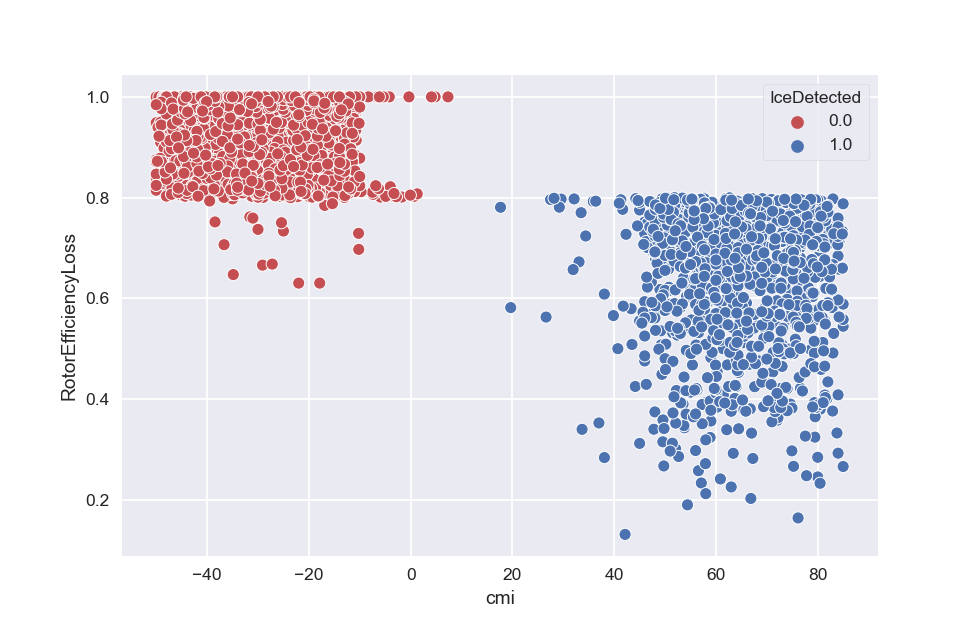

<IPython.core.display.Javascript object>


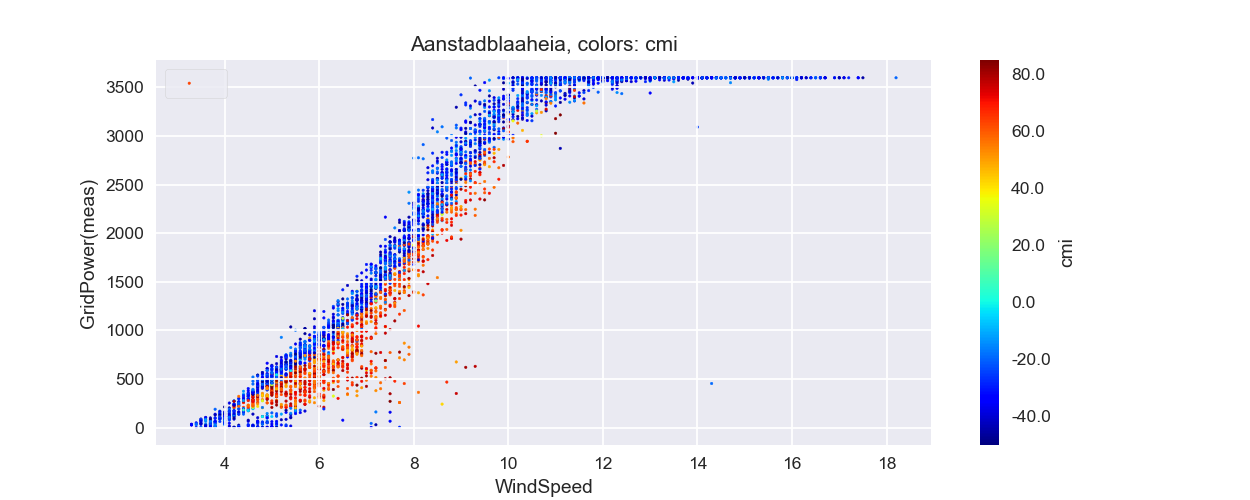

<IPython.core.display.Javascript object>


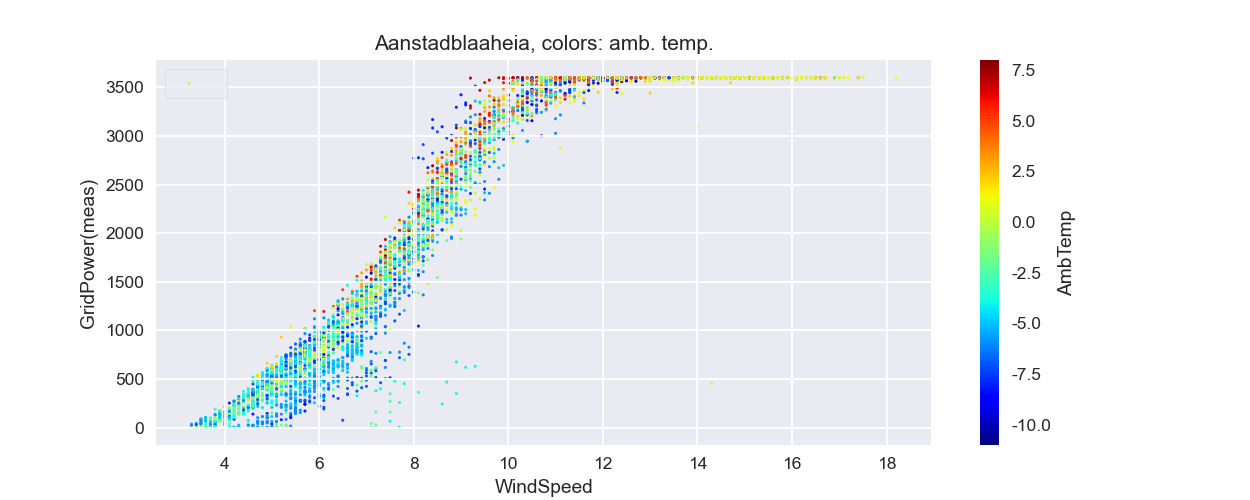

#### Svartnäs

loading C:\Users\w012028\Documents\Entwicklung\power_curve\power_curve_bild\Svartnäs_20211214_20220114.txt



#### Statistics

,WindSpeed,EstimatedWS,GridPower,AmbTemp,RotorEfficiencyLoss,cmi
count,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000
mean,8.267062,7.985880,1893.194696,-2.406636,0.845375,-1.698969
std,2.932875,3.040007,1263.030175,4.091500,0.158350,44.166216
min,3.300000,2.500000,0.200000,-11.000000,0.131681,-50.000000
25%,5.900000,5.600000,673.500000,-6.000000,0.766148,-34.250000
50%,7.800000,7.600000,1761.000000,-3.000000,0.887028,-22.000000
75%,10.100000,9.900000,3302.500000,1.000000,0.976254,52.571429
max,18.200000,17.600000,3602.900000,8.000000,1.000000,85.000000


<IPython.core.display.Javascript object>


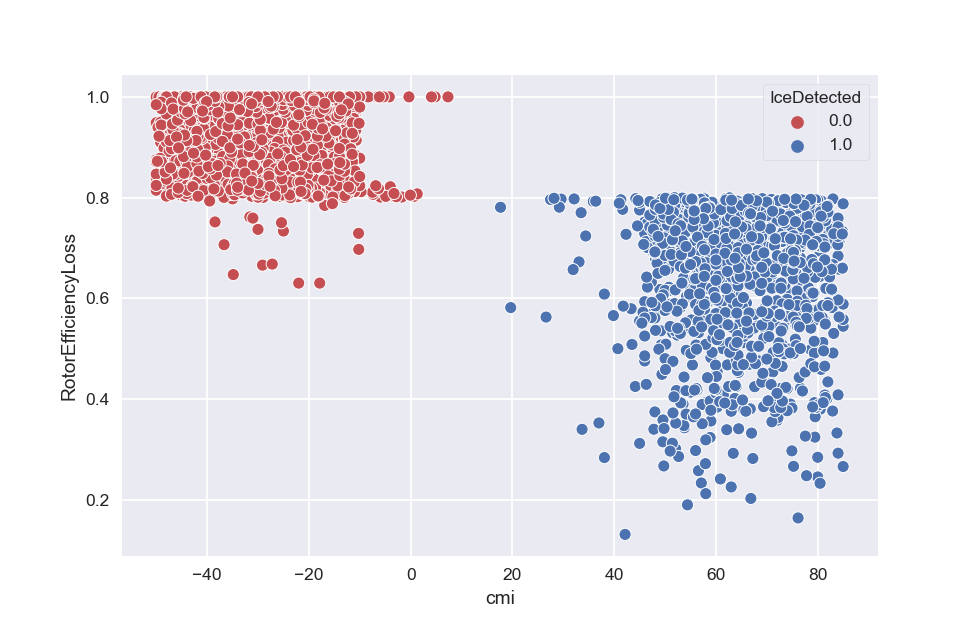

<IPython.core.display.Javascript object>


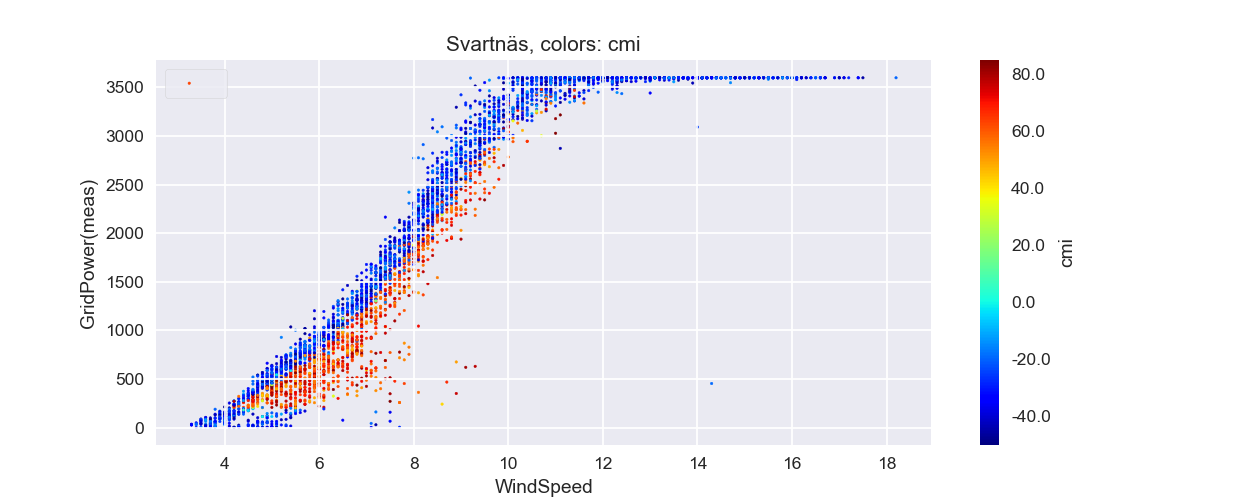

<IPython.core.display.Javascript object>


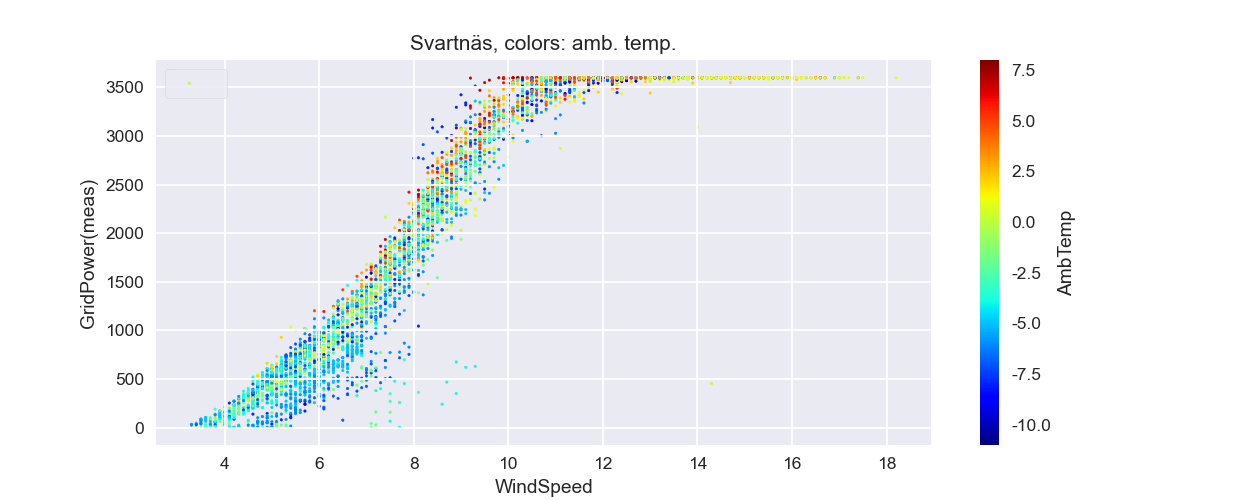

In [12]:
for fn in fns:
    name = fn.split('_')[0]
    display(Markdown("#### " + name))
    
    # load the power curve data and transform timestamp
    df_pw = load_csv(path_work1 / fns[1])
    df_pw = df_pw.assign(bin_time=df_pw.Time.apply(lambda t: epoch2dt(t)))
    
    # load the cmi data
    df_cmi = load_cmi(df_pw, dummy=True)
    
    # combine both
    dfint = pd.concat([df_pw.loc[:, ['bin_time', 'IceDetected']], 
                df_cmi.loc[:, ['create_time', 'cmi']].rename(columns={'create_time': 'bin_time'})])
    dfint = dfint.loc[:, ['bin_time', 'cmi']].set_index('bin_time')
    dfint.sort_index(inplace=True)

    dfint.interpolate(method='time', limit_direction='forward', inplace=True)
    
    df = df_pw.set_index('bin_time').merge(dfint.dropna(), how='left', left_index=True, 
                                           right_index=True).drop_duplicates(subset=['Time'])
    
    df = df.loc[df.GridPower>0,:]
    
    display(Markdown('#### Statistics'))
    cols_describe = ['WindSpeed', 'EstimatedWS', 'GridPower', 'AmbTemp', 'RotorEfficiencyLoss', 'cmi']
    display(df.loc[:, cols_describe].describe())
    
    print()
    fh = plt.figure()
    sns.scatterplot(data=df, x='cmi', y='RotorEfficiencyLoss', hue='AmbTemp', style='IceDetected')
    
    print()
    fn = None
    #fn = path_work1 / f'{name}_cmi.png'
    plot_target_feat_simplified(df, fn=fn, feature='WindSpeed', target='GridPower', var_colors='cmi', 
                                title=f'{name}, colors: cmi')
    print()
    fn = None
    #fn = path_work1 / f'{name}_temp.png'
    plot_target_feat_simplified(df, fn=fn, feature='WindSpeed', target='GridPower', var_colors='AmbTemp', 
                                title=f'{name}, colors: amb. temp.')

### Time stamp

This section contains some preanalysis how to treat the time stamp of the power curve data.

In [13]:
df_pw = load_csv(path_work1 / fns[1], verbose=True)

loading C:\Users\w012028\Documents\Entwicklung\power_curve\power_curve_bild\Svartnäs_20211214_20220114.txt

(4608, 7)


,Time,WindSpeed,EstimatedWS,GridPower,AmbTemp,RotorEfficiencyLoss,IceDetected
0,738503.958333,7.7,7.8,1866.6,0.0,0.22578,1.0
1,738503.965278,8.2,8.3,2240.5,0.0,0.45402,1.0
2,738503.972222,8.2,8.4,2348.6,0.0,0.69061,1.0


The time stamp is obviously some epoch time format. To identify its unit we consider two consecutive time values. 

In [14]:
for x in np.unique(np.diff(df_pw.Time)):
    print(f'{x*24*6}')

0.9999999906867743
1.0000000074505806


Except for rounding errors the time differences between successive data sets are identical. As the data are 10 min averages, this time difference is expected to be 10 min. Since the differences of the values of column 'Time' equal 10 / 24 / 60, the column contains the time since some epoch in days. 

To find the starting point of the epoch, the period contained in the file name will be used for comparison. This period is 2021-12-14 till 2022-1-14. Let's try to substract the beginning of year 1:

In [15]:
print(dt(2021,12,14)- dt(1,1,1))
print(df_pw.loc[0,'Time'])

738137 days, 0:00:00
738503.9583333334


It seems the starting point is the hypothetical date 0.0.0 as used in MATLAB e.g., cf. 

https://en.wikipedia.org/wiki/Epoch_(computing)#Notable_epoch_dates_in_computing

So the transformation to the usual datetime is 

*time = dt(0,0,0) + days in 'Time'*

Because datetime not allows dt(0,0,0), I will use dt(1,1,1) and substract the 366 days *manually*:

*time = dt(1,1,1) + days in 'Time' - 366 days*

This transformation will be used for the analysis. Applied to the data here this looks plausible:

In [16]:
print(epoch2dt(df_pw.iloc[0,0]))
print(epoch2dt(df_pw.iloc[-1,0]))

2021-12-14 23:00:00.000003
2022-01-15 22:49:59.999999


In [17]:
df_pw = df_pw.assign(bin_time=df_pw.Time.apply(lambda t: epoch2dt(t)))#dt(1,1,1)+timedelta(days=t-366)))

In [18]:
df_pw.head()

,Time,WindSpeed,EstimatedWS,GridPower,AmbTemp,RotorEfficiencyLoss,IceDetected,bin_time
0,738503.958333,7.7,7.8,1866.6,0.0,0.225780,1.0,2021-12-14 23:00:00.000003
1,738503.965278,8.2,8.3,2240.5,0.0,0.454020,1.0,2021-12-14 23:09:59.999998
2,738503.972222,8.2,8.4,2348.6,0.0,0.690610,1.0,2021-12-14 23:20:00.000002
3,738503.979167,8.2,8.4,2311.7,0.0,0.927199,0.0,2021-12-14 23:29:59.999997
4,738503.986111,8.2,8.4,2379.3,0.0,0.938008,0.0,2021-12-14 23:40:00.000001


### CMI data

The cmi data must be retrieved from the cmrblba data bases or from the hd5 files. The result of the respective query should be a dataframe with one column 'create_time' and one column 'cmi'. As long as the real data cannot be retrieved some simulated dummy data will be used as implemented in the function *load_cmi* above. 

In [19]:
df_cmi = load_cmi(df_pw, dummy=True)

### Combining the data

Now both dataframes will be combined. To do so, for each bin_time value of dataframe df the next nearest create_time values of df_cmi will be found and the cmi value will be linearly interpolated between these two values. If there are no two values, the next value will be used instead (**Note:** extrapolation could be conducted instead, but since this is a bigger effort and it can effect only to data points at the most, this simpler version will be used here)

In [20]:
dfint = pd.concat([df_pw.loc[:, ['bin_time', 'IceDetected']], 
                df_cmi.loc[:, ['create_time', 'cmi']].rename(columns={'create_time': 'bin_time'})])
dfint = dfint.loc[:, ['bin_time', 'cmi']].set_index('bin_time')
dfint.sort_index(inplace=True)
dfint.head()

,cmi
bin_time,
2021-12-14 23:00:00.000003,NaN
2021-12-14 23:00:00.000003,63.0
2021-12-14 23:09:59.999998,NaN
2021-12-14 23:10:59.999998,72.0
2021-12-14 23:20:00.000002,NaN


In [21]:
dfint.interpolate(method='time', limit_direction='forward', inplace=True)
dfint.head()

,cmi
bin_time,
2021-12-14 23:00:00.000003,NaN
2021-12-14 23:00:00.000003,63.000000
2021-12-14 23:09:59.999998,71.181818
2021-12-14 23:10:59.999998,72.000000
2021-12-14 23:20:00.000002,61.615385


In [22]:
df = df_pw.set_index('bin_time').merge(dfint.dropna(), how='left', left_index=True, right_index=True).drop_duplicates(subset=['Time'])
df.head()

,Time,WindSpeed,EstimatedWS,GridPower,AmbTemp,RotorEfficiencyLoss,IceDetected,cmi
bin_time,,,,,,,,
2021-12-14 23:00:00.000003,738503.958333,7.7,7.8,1866.6,0.0,0.225780,1.0,63.000000
2021-12-14 23:09:59.999998,738503.965278,8.2,8.3,2240.5,0.0,0.454020,1.0,71.181818
2021-12-14 23:20:00.000002,738503.972222,8.2,8.4,2348.6,0.0,0.690610,1.0,61.615385
2021-12-14 23:29:59.999997,738503.979167,8.2,8.4,2311.7,0.0,0.927199,0.0,-19.941176
2021-12-14 23:40:00.000001,738503.986111,8.2,8.4,2379.3,0.0,0.938008,0.0,-42.294118


## 1 Theorie

Prinzip: Die kinetische Energie des Windes wird in die Drehbewegung der Turbine umgewandelt, ein Teil davon wird als elektrische Energie entnommen.

Betrachtung der Drehmomente: Im stationären Zustand, d.h. bei konstanter Drehzahl (über den Zeitraum der Messung betrachtet), ist das Gesamtdrehmoment gleich 0:

$$M_{blades, net} + M_{el} = 0$$

bzw. nach Multiplikation mit der Winkelgeschwindigkeit $\omega$:

$$\omega M_{blades, net} + P_{el} = 0$$

Der Nettowert setzt sich zusammen aus dem "echten" antreibenden Moment infolge des Auftriebs an den Rotorblättern abzüglich des Bremsmoments infolge des Luftwiderstandes. Die Gleichungen lauten wie folgt (s. Siegfried Heier: Windkraftanlagen):

In [ ]:
Image(filename=path_img / 'formeln.jpg')

Dabei:

* $r$: Radius des Blattelements
* $z$: Anzahl der Rotorblätter, d.h. $z=3$
* $\rho$: Luftdichte
* $t_B$: Blatttiefe am Radius $r$
* $v_r$: resultierende Anströmgeschwindigkeit, $v_r^2=v_{2,ax}^2+\left(\omega r+v_{2,t}\right)^2 = v_2^2+\omega^2 r^2 + 2 \omega r v_{2,t}$
* $c_a$: Auftriebsbeiwert
* $c_w$: Widerstandsbeiwert
* $\delta$: Winkel zwischen Rotorebene und Anströmgeschwindigkeit, Summe aus Pitchwinkel, Twistwinkel und "angle of attac", $\delta = \theta_p + \Delta + \alpha$, es gilt $\tan \delta = \frac{v_{2,ax}}{v_{2,t}+\omega r}$. Damit hängt $\delta$ vom Radius $r$ ab, ebenso $\Delta$ und damit auch $\alpha$. Die Annahme ist nun, dass das Blatt so verdreht ist, dass der angle of attack ungefähr konstant ist über die Blattlänge TODO WEITER AUSARBEITEN

Wegen $\delta(r) = \theta_{pitch} + \Delta(r) + \alpha(r) =: \theta_{pitch} + \tilde{\alpha}(r)$ 
folgt mit Hilfe der Additionstheoreme

$$cos(a+b)=cos(a)cos(b)-sin(a)sin(b)\quad \text{und} \quad sin(a+b)=sin(a)cos(b)+cos(b)sin(a)$$

und mit der Annahme $v_{2,t}=0$ die Zerlegung

$$\begin{eqnarray*}
M_{aw} &=& z \, \frac{\rho}{2}\, v_2^2\, sin\, \theta_p \int_{R_1}^{R_2} dr \, t_B(r) \, \left(c_a \, cos \,\tilde{\alpha}(r) + c_w\, sin\, \tilde{\alpha}(r) \right) \\
&\phantom{=}& + z \,\frac{\rho}{2}\, v_2^2\, cos\, \theta_p \int_{R_1}^{R_2} dr\, t_B(r)\, \left(c_a\, sin\, \tilde{\alpha}(r) - c_w\, cos\, \tilde{\alpha}(r) \right) \\
&\phantom{=}& + z \, \frac{\rho}{2}\, \omega^2\, sin\, \theta_p \int_{R_1}^{R_2} dr \, t_B(r) \, r^2 \, \left(c_a \, cos \,\tilde{\alpha}(r) + c_w\, sin\, \tilde{\alpha}(r) \right) \\
&\phantom{=}& + z \,\frac{\rho}{2}\, \omega^2\, cos\, \theta_p \int_{R_1}^{R_2} dr\, t_B(r)\, r^2\, \left(c_a\, sin\, \tilde{\alpha}(r) - c_w\, cos\, \tilde{\alpha}(r) \right)
\end{eqnarray*}$$

Die Integranden sind in niedrigster Ordnung unabhängig von den Betriebsdaten, d.h. die Integrale sind jeweils Konstanten. 
Als Näherung der Luftdichte folgt aus der allgemeinen Gasgleichung

$$\begin{eqnarray*}
\rho = \frac{p}{R_S \cdot T}
\end{eqnarray*}$$

mit der um die Luftfeuchte korrigierten Gaskonstanten $R_S$. 

Die elektrische Leistung setzt sich zusammen aus dem Eigenverbrauch der WEA und der ans Netz abgegebenen Leistung $P$ ("power_mean" in unseren Daten):

$$\begin{eqnarray*}
P_{el}=P + P_{el,\, WEA}
\end{eqnarray*}$$

Für den Eigenverbrauch sei noch angenommen, dass dieser beim Pitchen und Yawen steigt, d.h.

$$\begin{eqnarray*}
P_{el,\, WEA} &=& P_0 + \beta_5 \, \sigma(\theta_p) + \beta_6 \, \sigma(\theta_{az})
\end{eqnarray*}$$

Insgesamt ergibt sich damit folgender Zusammenhang:

\begin{eqnarray*}
P &=& -P_0 + \beta_1 \, \frac{v_2^2 \omega}{T} \, cos \, \theta_p + \beta_2 \, \frac{v_2^2 \omega}{T} \, sin \, \theta_p + \beta_3 \, \frac{\omega^3}{T} \, cos \, \theta_p + \beta_4 \, \frac{\omega^3}{T} \, sin \, \theta_p + \beta_5 \, \sigma(\theta_p) + \beta_6 \, \sigma(\theta_{az})
\end{eqnarray*}

#### Modifikation 2021-9-25:

In [ ]:
HIER NOCH MODIFIKATIONEN VOM 25.9. eintragen

Ansätze:

1. möglichst gute Näherungen für $t_b(r)$ und $\Delta(r,\omega)$ ansetzen und Integral tatsächlich integrieren, dann im Resultat Terme mit den Betriebsdaten als Regressionsvariablen verwenden bzw. Differenz zwischen tatsächlicher Leistung und erwarteter bilden und Residuen mit geeigneten Modellen und Methoden (dumme Regressionsmodelle, aber auch irgendwelche anderen ML-Verfahren, dabei ruhig versuchen, das Letzte herauszukitzeln) fitten
2. arctan-Funktion nähern (stückweise konstant oder linear), dabei anhand der möglichen minimalen und maximalen Werte der Betriebsdaten geeignete Näherungen auswählen, mit den Näherungsfunktionen dann die Integrale ausrechnen und die entsprechenden transformierten Variablen für das Regressionsmodel bestimmen
3. Annahme, dass aoa konstant ist. Dies zuerst anhand der Daten prüfen. Falls bestätigt, dann entsprechende Regressionsgleichungen (nochmal richtig) aufstellen und Regression durchführen

In [ ]:
TODO 2021-2-4: fuer \tilde(alpha) stimmt das mit der niedrigsten Ordnung Integranden = const. evtl. nicht, hier koennten die sin-Terme ~ alpha sein in niedrigster Ordnung. Da tilde(alpha)=arctan(v/w R) - pitch gilt, haette man noch die Abhaengigkeit von omega und v drin.
    wie es auf den ersten Blick aussieht, lassen sich die Integrale mit $\delta$ vor der Ersetzung durch theta+alpha direkt berechnen, WENN t_b konstant ist (oder viell. linear genaehert werden kann) und die c_a/c_w konstant sind
    --> machen (aber bisherige Rechnungen erstmal beibehalten, weil sie so gut funktionieren) und auch als Modell verwenden, ebenso Entwicklung von $c_a$ und $c_w$ nach alpha machen (bis O(1) bzw. O(2)) und dann nochmal alles ansehen und bestes Modell auswaehlen
    
--> ausserdem immer noch klaeren, wieso die aoa-Winkel so gross sind!

## 2 Vorbereitung

Import der Bibliotheken, Festlegen der Parameter und Zwischenspeichern von Daten

In [ ]:
from kinematics.pitch import calc_pitch_bending, calc_pitch2, calc_pitch_period, raw2pitch, get_raw_data, calc_pitch_diff, get_ef
from kinematics.pitch import calc_pitch_df, get_data_from_dbs30, digits2g, digits2g_df#, digits2si
from kinematics.pitch import butter_lowpass_filter
from data import calc_phi_from_harmonics, get_preferences
#from plot.myFunctions_plot import myplot_fast, myplot_fast2, myplot_fast3

In [ ]:
# function to append column with aoa (in degrees), note that 'omega_mean' is in fact the rotor frequency, not 2 \pi * rotor frequency!
def append_aoa(df, radius = 2):
    #tmp = df.loc[:, 'wind_mean'].div(df.loc[:, 'omega_mean']).div(radius)
    #angle_of_attac=90-(np.arctan(tmp)*180/np.pi-df.pitch_mean.values)
    tmp = df.loc[:, 'wind_mean'].div(df.loc[:, 'omega_mean']*2*np.pi*radius)
    angle_of_attac=np.arctan(tmp)*180/np.pi-df.pitch_mean.values
    return(df.assign(aoa_deg=angle_of_attac))

In [ ]:
# function to retrieve information about the wind turbine - TODO: noch flexibler machen
def get_wt_info(db):
    fields_pit = ['Windpark_WEA#Windparkname', 'WEA_Name', 'Datenbankname', 'WEA_Typ#Name', 'WEA_Typ#Rotorblatt_Typ#Name']
    df = query_tableData_PIT('VIEW_Windkraftanlagen', listCols = fields_pit, sWhereClause = f"Datenbankname='{db}'")
    tmp = df.iloc[0]
    farm = tmp['Windpark_WEA#Windparkname']
    tb = tmp['WEA_Name']
    tb_type = tmp['WEA_Typ#Name']
    blade_type = tmp['WEA_Typ#Rotorblatt_Typ#Name']
    info = f'{farm}, {tb} ({db}), {tb_type}, {blade_type}'
    return(info)

In [ ]:
green_diamond = dict(markerfacecolor='green', marker='D')

Für eine schnellere Verarbeitung werden -soweit verfügbar- die Daten aller Turbinen aus den Datenbanken ausgelesen und in pickle-Dateien zwischengespeichert.

## 3 Leistungskurve ausschließlich anhand SCADA-Betriebsdaten (ohne CMS-Daten)

Hier werden die Leistungskurven anhand der Betriebsdaten modelliert (später wird untersucht, ob sich bei Verwendung des aus den CMS-at-Messungen bestimmmten Pseudo-Pitchwinkels bessere Modelle ergeben). Zunächst werden für einige Beispielanlagen die Daten geladen und die Modelle berechnet.

Liste mit Beispielanlagen in der Form (Windpark, WEA):

In [ ]:
list_samples = [('Reinsdorf II', 'Vestas 224964'), ('Anstadblaheia', 'Vestas 219445'), ('Hintersteinau I + II', 'Vestas 219900')]

In [23]:
for (a,b) in tuple(df.loc[df.a==1, ['b', 'c']].values):
    print(f'{a}: {b}')

2: a
2: c


In [25]:
tuple(df.loc[df.a==1, ['b', 'c']].values)

(array([2, 'a'], dtype=object), array([2, 'c'], dtype=object))

In [ ]:
# besser fixe Daten verwenden als z.B. dt.now(), da dann die Daten einfach wieder aus den pkl-files geladen werden koennen und 
# ausserdem verschiedene Notebook-Durchlaeufe vergleichbar sind
end_time = dt(2022,4,15)
start_time = dt(2021,4,15)
#model = None

m1 = pipeline(selector, transformer, model, name + infos)
m2 = pipeline(...)
m3 = pipeline(...)

filters = {'create_time': (start_time, end_time), 'power_mean': (200, np.inf), 'power_sigma': (0, 50), 
           'omega_sigma': (0, .5), 'wind_sigma': (0, 3)}

# loop through all turbines and apply the models
for i, (farm, turbine) in enumerate(list_samples):
    myprint(f'{i}: {farm}, {turbine}')
    
    cpc = cpc.from_farm_and_name(farm, turbine, path_data=path_data, path_work=path_work)

    filters.update({'omega_mean': (cpc.omega_min, np.inf)})
    cpc.load_data(filters=filters)

HIER WEITER 2022-4-18
#    cpc.set_model([m1, m2, m3])
    
#    cpc.fit()
    
#    cpc.print_model_quality()
    
#    cpc.plot_pc()  
    

In [ ]:
Note: for the "normal" work with the power curve the ba_cycle_measurement_cycle might be easier because they are not so large data sets. For special considerations like considering the power used for pitching or yawing the ba_cycle_status data might be of interest because the 

In [ ]:
pc = power_curve(db='cmrblba_bc_t_03001', period=(dt(2021,1,1), dt.now()), use_at=True, exclude_periods={'edge_1': (dt(2021,1,1), dt(2021,3,19))}
                
model1 = pipeline(...)
model2 = pipeline(...)
model3 = pipeline(...)
                 
pc.load_data(filters={})


## 3 Voruntersuchung zum Pitchwinkel und AoA

Um möglichst saubere Daten zu haben werden nur Zeitdaten verwendet. Für die at-Zeitreihen werden die Pitchwinkel bestimmt (s. Notebook *pitch_angle_calculation*), außerdem werden die Daten noch mit dem cmi aus den icing-Peak-Daten kombiniert.

### Tests um at-Daten von hd5-Dateien einzulesen

In [ ]:
TODO:
    
* hier testen anhand einer WEA
* dann in Funktion auslagern
* diese in repositry in data ablegen
* in pitch_angle_calculation-Notebook die Funktion auch verwenden

#### Entwicklung der Funktion an einer WEA

In [ ]:
TODO 2021-9-25:
    - nach Rueckkehr SB fragen, wie er Zeitdaten laedt aus hd5
    - Funktion dann hier anwenden, zum Laufen bekommen, anschliessend die eigentlichen Untersuchungen durchfuehren
    - noch von alten Files (und bes. SQLalchemy) von MG wegkommen, Datensammeln umstellen und seine Sachen abkoppeln und ins Archiv

In [ ]:
from pathlib import Path
from wms.dbs import weadbs, hdf5, pit
#from wms.defects import mask_defect_data
from wms.utils import CompactPeriods

sedpath = Path('W:')
db = 'bc_t_01730'
#from_hdf(cls, path, where={}, create_times=None, return_N=False,
#                 prefix=''):
sed = weadbs.SEData.from_hdf2(sedpath / 'data' / 'batch-3' / 'bc_t_01730' / 'packed' / f'{db}_at_0.h5')#.select_st(where)     

In [ ]:
from pathlib import Path
from wms.dbs import weadbs, hdf5, pit
#from wms.defects import mask_defect_data
from wms.utils import CompactPeriods

sedpath = Path('W:')
db = 'cmrblba_bc_t_01730'
sed = weadbs.SEData.from_hdf(sedpath / 'data' / 'batch-3' / 'bc_t_01730' / 'packed' / f'{db}_at_0.h5')#.select_st(where)     

In [ ]:
path_work = r'C:\Users\w012028\Documents\Entwicklung\power_curve\work\20210925'

In [ ]:
sedpath = Path('W:')

In [ ]:
db = 'cmrblba_bc_t_01730'

In [ ]:
filters_raw = ['r2e >= 0.9', 'r2f >= 0.75', 'f_rot < 0.3']#, 'pitch<50']
period = (dt(2020,9,1), dt(2021,9,1))
kwargs = {'filters': 'omega_mean>=0.05', 'blades': range(1,4), 
          'sample_rate': 1000, 'wdw_size_prae': 101, 'min_amp': 200}

In [ ]:
sed = weadbs.SEData.from_hdf(sedpath / 'data' / 'batch-3' / 'bc_t_01730' / 'packed' / f'{db}_at_0.h5')#.select_st(where)     

In [ ]:
def load_hd5_data(db, fn_sed, sedpath=pathlib.Path(r'C:\\Users\\w012028\\PycharmProjects\\Blitzschaden\\data\\sed'), 
                  hdfdir3=r'C:\Users\w012028\PycharmProjects\Blitzschaden\data'):

    # if file of combined sed already exists then read only this, otherwise combine the data to it
    if fn_sed in os.listdir(sedpath):
        sed = weadbs.SEData().from_hdf(sedpath / fn_sed)
        
    else:
        interval_i = list(range(1,6))
        hdfdirs = {i: pathlib.Path(r'W:\\data') / f'batch-{i}' / db for i in interval_i}
        hdfdirs.update({3: pathlib.Path(hdfdir3) / 'batch-3' / db})
        
        st_columns = ['ID', 'omega_mean', 'omega_sigma', 'pitch_mean', 'pitch_sigma', 'power_mean', 'power_sigma', 
                      'wind_mean', 'wind_sigma', 'temperature_mean', 'available_data']
        
        for i, hdfdir in hdfdirs.items():
            try:
                loader = hdf5.AF2SED(hdfdir, st_columns=st_columns, sedpath=sedpath / f'SED_{db}_{i}.h5')
                cts, _, _ = loader.load(channels='blades')
            
            except Exception as err:
                print(f'Problem mit batch-{i}')
                interval_i = [k for k in interval_i if k!=i]
        
        # ohne das Filtern nach available_data und dem drop_duplicate bleiben im Endergebnis noch Duplikate 
        # drin, die zudem noch asynchron sind, d.h. bei ausfuehren von drop_duplicates() am finalen SED-Objekt
        # entstehen sed.st und sed.se mit unterschiedlichen shapes
        where = {'available_data': [1,2]}
        sed = weadbs.SEData.from_hdf(sedpath / f'SED_{db}_{interval_i[0]}.h5').select_st(where)                
        for i in interval_i[1:]:
            sed = sed.append(weadbs.SEData.from_hdf(sedpath / f'SED_{db}_{i}.h5').select_st(where))
                
        tmpst = sed.st.drop_duplicates(keep='last')
        tmpse = sed.se.drop_duplicates(keep='last')        
        bst = (tmpst.shape[0]!=sed.st.shape[0])
        bse = (tmpse.shape[0]!=sed.se.shape[0])
        if bst and bse:
            sed = sed._replace(se=tmpse, st=tmpst)
        else:
            if bst or bse:
                print(f'sth is strange with sed for {db}')
        
        sed.to_hdf(sedpath / fn_sed)
        
    return(sed)

In [ ]:
df_raw = get_raw_data(db, path_work, period, **kwargs)

In [ ]:
def load_at(db, period, HIER_NOCH_PARAMETERS_FOR_PITCH_ANGLE_CALCULATION):
        df_raw = get_raw_data(db, path_work, period, **kwargs)
               
    df_pitch = raw2pitch(df_raw, filters_raw)


In [ ]:
df_pitch = raw2pitch(df_raw, filters_raw)

## 3 Statistik der empirischen Leistungskurven

Für die IB der VIDs ist es sehr nützlich, auch mit Zyklen bei tiefen Temperaturen lernen zu können. Ein Ansatz um solche Zyklen ohne Eis zu identifizieren ist die Verwendung der Leistungskurve.
Hier sollen die Leistungskurven für alle VID-WEAs betrachtet werden und festgestellt werden, ob sich verschiedene statistische Eigenschaften (z.B. 1%-Quantil) über Anlagen(typen) hinweg signifikant unterscheiden.
Mehr Details zur VID-IB siehe (PyCharm-)Projekt VID_task_tracker2.

In [ ]:
path_vid_data = r'C:\Users\w012028\PycharmProjects\VID_task_tracker2\fast_calibration\data'
path_vid_results = r'C:\Users\w012028\PycharmProjects\VID_task_tracker2\fast_calibration\results'

### 3.1 Laden VID-WEAs

In [ ]:
dict_pit = {'Windpark_WEA#Windparkname': 'farm', 
            'WEA_Name': 'turbine', 
            'WEA_Typ#Name': 'turbine_type',
            'Datenbankname': 'db',
            'WEA_Typ#Rotorblatt_Typ#Name': 'blade_type'}
where_clause="(Datenbankname like '%vid_%') and not ((Datenbankname is NULL) or (Datenbankname = '') or (Beginn_Datenspeicherung is NULL) or (Beginn_Datenspeicherung = '') or (WEA_Typ#Name is NULL) or (WEA_Typ#Name='') or (WEA_Typ#Rotorblatt_Typ#Name is NULL) or (WEA_Typ#Rotorblatt_Typ#Name=''))"
df_vid = query_tableData_PIT(cols=list(dict_pit.keys()), where_clause=where_clause).rename(columns=dict_pit)
print(f'{df_vid.shape[0]} Anlagen gefunden')
df_vid.head()

In [ ]:
b_new = df_vid.turbine_type.apply(lambda s: int(s.split('/')[0].replace('Vestas V', ''))>=126)
turbines_vid = df_vid.loc[b_new, :]
print(turbines_vid.shape)
turbines_vid.head()

In [ ]:
turbines_vid.turbine_type.value_counts()

In [ ]:
vids = turbines_vid.db

### 3.2 Zwischenspeichern der Daten

In [ ]:
# daten mit act. avg. freq laden, dann pickeln, vorher noch nas entfernen etc.

In [ ]:
# TODO: noch in Extra-Fkt. auslagern
def dict2where_clause(filters, tab_name=''):

    if (filters is None) or (filters=={}):
        return('')

    else:
        tmp = []
        if not(tab_name==''):
            tab_name=f'{tab_name}.'
            
        for k,v in filters.items():
            if not(v[0] is None):
                tmp.append(f'{tab_name}{k}>={v[0]}')
            if not(v[1] is None):
                tmp.append(f'{tab_name}{k}<{v[1]}')
        stmp = ') and ('.join(tmp)
        return f'({stmp})'

In [ ]:
#
# TODO: noch ausladen in Extra-funktionen in my repository
#
def load_data_vid(db, path, period=(), filters={}, overwrite=True):#, tab='cyc'):#, filters = None):

    cols_b = ['create_time', 'ID', 'temperature_mean', 'wind_mean', 'wind_sigma', 'pitch_mean', 
              'pitch_sigma', 'azimuth_mean', 'azimuth_sigma', 'omega_mean', 'omega_sigma', 
              'power_mean', 'power_sigma']
    cols_i = ['actual_avg_freq']
    
    tab = 'ba_cycle_measurement_cycle'
    tab_short = 'bcmc'
    fn = f'{db}__{tab_short}.pkl'
    retrieve = True
    try:
        if (fn in os.listdir(path)):            
            df = pd.read_pickle(f'{path}\\{fn}')
            # if parameters of existing .pkl-file are different from current values then load new
            try:
                retrieve = not(df.attrs['period']==period and df.attrs['filters']==filters)
            except:
                pass
        
        
        if retrieve:
            f2 = {k:v for k,v in filters.items()}
            if not(period==()):
                f2.update({'create_time': period})

            wc = dict2where_clause(f2,tab_name='b')
            if wc=='':
                wc = '(i.obj_id=1000)'
            else:
                wc = f'(i.obj_id=1000) and {wc}'

            tmp_b = ','.join([f"b.{c}" for c in cols_b])
            tmp_i = ','.join([f"i.{c}" for c in cols_i])
            query = (f'select {tmp_b}, {tmp_i} '
                     f'from {tab} b inner join ba_cycle_icing_peak i '
                      'on b.create_time=i.create_time '
                     f'where {wc};')

            res = query_MySQL2(db, query)

            df = pd.DataFrame.from_records(res, columns=cols_b+cols_i).dropna(axis=1, how='all').dropna(axis=0,how='all')
            df.attrs['period'] = period
            df.attrs['filters'] = filters
            if overwrite and not(df.empty):
                df.to_pickle(f'{path}\\{fn}')
            
    except Exception as err:
        #print(str(err))
        df = pd.DataFrame(columns=cols_b+cols_i)
        
    return df

In [ ]:
start, end = dt(2020,9,20), dt(2021,9,20)
sstart, send = "20200920000000", "20210920000000"
filters = {'power_mean': (200, None), 'omega_mean': (0.05, None), 'power_sigma': (None, 50), 
           'omega_sigma': (None, .5), 'wind_sigma': (None, 3)}

In [ ]:
for i, db in enumerate(vids):
    myprint(f"{i+1}/{len(vids)}")
    _df = load_data_vid(db, path_vid_data, period=(sstart, send), filters=filters, overwrite=True)

### 3.3 Statistiken der Leistungskurven

Folgende Punkte werden untersucht:
    
1) Welches Quantil muss verwendet werden, um die Werte mit hohem cmi gut auszuschließen? 

* Ist dieses mit den hohen cmi-Werten zu bilden oder ohne? 
* Nur für $T>5^o C$ oder auch für tiefe Temperaturen?
    
2) Wie hängt der Verlauf des Quantils vom Anlagen- und Rotorblatttyp ab?

#### Geeignete Quantile

In [ ]:
def filters2str(filters):
    tmp = []
    for k, (l,u) in filters.items():      
        if not((l is None) or (u is None)):
            tmp.append(f'{l}<={k}<{u}')
            
        elif (l is None) and not(u is None):
            tmp.append(f'{k}<{u}')
            
        elif not(l is None) and (u is None):
            tmp.append(f'{l}<={k}')
              
    return(', '.join(tmp))

In [ ]:
def plot_pw_wind(df, title=None, dict_quantiles={'q': 0.05, 'bin_width': .02}, thres_cmi=75, 
                 var_colors='actual_avg_freq', xlim=[3,15], ylim=[0,3500], fn=None):
    
    #if fn is None:
    #    plt.ioff()
    
    #df = df[df.actual_avg_freq>30]
    if title is None:
        title = f"Power curve of"
    title = title + f" (n={df.shape[0]})"

    try:
        filters = df.attrs['filters']
        if (filters=={}):
            sfilters = 'no filters'
        else:
            sfilters = filters2str(filters)
    except Exception as err:
        sfilters = str(err)
            
    title = title + '\n' + sfilters
    
    cmap = plt.cm.get_cmap('Oranges')   # 'jet'
    fig, ax = plt.subplots(figsize=(9, 6))
    fig.canvas.set_window_title("plot_pw_wind " + title)

    ix_grey = df.loc[df.actual_avg_freq<=thres_cmi,:].index
    ax.scatter(df.loc[ix_grey, 'wind_mean'], df.loc[ix_grey, 'power_mean'], s=2, color='grey', zorder=-1)
    
    ix_color = df.loc[df.actual_avg_freq>thres_cmi,:].index
    
    def markersize(cmi, rmin=2, rmax=20, cmi_max=200):
        return(rmin + (rmax-rmin)/ cmi_max * min([cmi, cmi_max]))

    ms_values = df.loc[ix_color, 'actual_avg_freq'].apply(lambda cmi: markersize(cmi)).values

    im = ax.scatter(df.loc[ix_color, 'wind_mean'], df.loc[ix_color, 'power_mean'], s=ms_values, 
                    c=df.loc[ix_color, var_colors].values, cmap=cmap, zorder=-1)
    
    if not(dict_quantiles is None):
        q = dict_quantiles['q']        
        bin_width = dict_quantiles['bin_width']
        bins = pd.interval_range(start=0, end=df.wind_mean.max()+bin_width, freq=bin_width)
        
        df2 = df.assign(wind_bins=pd.cut(df.wind_mean, bins))
        
        df3l = df2.loc[:, ['wind_bins', 'power_mean']].groupby('wind_bins').quantile(q).reset_index(drop=False)
        # TODO 2021-9-21: noch eleganter machen (mit mapping oder so, viell. auch eingebaute Funktion), geringe Prio
        df3l = df3l.dropna(subset=['power_mean'], axis=0).assign(wind_bin_center=df3l.wind_bins.apply(lambda x: np.mean([x.left, x.right])))
        
        #df3u = df2.loc[:, ['wind_bins', 'power_mean']].groupby('wind_bins').quantile(.95)
        #df3u = df3u.assign(wind_bin_center=df2.wind_bins.mean())
        
        ax.plot(df3l.wind_bin_center, df3l.power_mean, color='black', linewidth=1)
        #ax.scatter(df3l.wind_bin_center, df3l.power_mean, c='b', label=f'q={q}', linewidth=1, linestyle='-', 
        #           marker='None')
        
        title = title + f'; q={q}'
    # quantile
    
    #im = ax.scatter(df_fltrd['wind_mean'], df[self.target], c=df_fltrd[var_colors].values, s=1, cmap=cmap, 
    #                zorder=-1)
            
    cbar = fig.colorbar(im, ax=ax, format='%d')
    cbar.set_label(var_colors)
    plt.title(title)
    #plt.legend(sleg, markerscale = 5)
    plt.xlabel("wind speed / $ms^{-1}$")
    plt.ylabel("power / $kW$")
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.grid(True)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)#rect=[0, 0.03, 1, 0.95])
    
    if fn is None:
        plt.show()
            
    else:
        fig.savefig(fn, dpi=350)
#        plt.ion()
        plt.close()
        
    return(None)

WEA mit der größten .pkl-Datei:

In [ ]:
db = 'cmrblba_vid_v220015'

In [ ]:
df = load_data_vid(db, path_vid_data, period=(sstart, send), filters=filters, overwrite=True)
df.shape

In [ ]:
df.attrs

In [ ]:
tmp = df_vid.loc[df_vid.db==db]
turbine_type = tmp['turbine_type'].values[0]
ymax = np.ceil(int(turbine_type.split('/')[1][:5])/500)*500
            
title = (f"{tmp['farm'].values[0]}, {tmp['turbine'].values[0]} ({db}): "
         f"{turbine_type} with {tmp['blade_type'].values[0]}")
            
fn = Path(path_vid_results) / f'{db}__P_vs_wind.png'
#plot_pw_wind(df, title=title, dict_quantiles={'q': 0.01, 'bin_width': 0.5}, thres_cmi=75, var_colors='actual_avg_freq', ylim=[0,ymax], fn=Path(path_vid_results)/'test.png')
plt.ioff()
x=plot_pw_wind(df, title=f"Power curve {db}", dict_quantiles={'filters': {}, 'q': 0.01, 'bin_width': 0.5}, 
             thres_cmi=75, var_colors='actual_avg_freq', ylim=[0,6000], fn=Path(path_vid_results)/'test.png')
plt.ion()

In [ ]:
plt.ioff()
not_done = []
for db in vids:
    try:
        df = load_data_vid(db, path_vid_data, period=(sstart, send), filters=filters, overwrite=True)
        if df.shape[0]<500:
            #print(f'{db}: only {df.shape[0]} values')
            not_done.append(db)
        else:
            tmp = df_vid.loc[df_vid.db==db]
            turbine_type = tmp['turbine_type'].values[0]
            ymax = np.ceil(int(turbine_type.split('/')[1][:5])/500)*500 + 300
            
            title = (f"{tmp['farm'].values[0]}, {tmp['turbine'].values[0]} ({db}): "
                     f"{turbine_type} with {tmp['blade_type'].values[0]}")
            
            fn = Path(path_vid_results) / f'{db}__P_vs_wind.png'
            plot_pw_wind(df, title=title, dict_quantiles={'q': 0.02, 'bin_width': 0.5}, thres_cmi=30, 
                         var_colors='actual_avg_freq', ylim=[0,ymax], fn=fn)
    except Exception as err:
        print(f'{db}: {str(err)}')
plt.ion()
print(f'\n{len(not_done)} of {len(vids)} turbines omitted')

Again, only for old wind turbine types:

In [ ]:
b_old = df_vid.turbine_type.apply(lambda s: int(s.split('/')[0].replace('Vestas V', ''))<126)
turbines_old = df_vid.loc[b_old, :]
print(turbines_old.shape)
turbines_old.head()

In [ ]:
#plt.ioff()
not_done = []
for db in turbines_old.db:
    try:
        df = load_data_vid(db, path_vid_data, period=(sstart, send), filters=filters, overwrite=True)
        if df.shape[0]<500:
            #print(f'{db}: only {df.shape[0]} values')
            not_done.append(db)
        else:
            tmp = df_vid.loc[df_vid.db==db]
            turbine_type = tmp['turbine_type'].values[0]
            ymax = np.ceil(int(turbine_type.split('/')[1][:5])/500)*500 + 300
            
            title = (f"{tmp['farm'].values[0]}, {tmp['turbine'].values[0]} ({db}): "
                     f"{turbine_type} with {tmp['blade_type'].values[0]}")
            
            fn = Path(path_vid_results) / f'{db}__P_vs_wind.png'
            plot_pw_wind(df, title=title, dict_quantiles={'q': 0.02, 'bin_width': 0.5}, thres_cmi=30, 
                         var_colors='actual_avg_freq', ylim=[0,ymax], fn=fn)
    except Exception as err:
        print(f'{db}: {str(err)}')
#plt.ion()
print(f'\n{len(not_done)} of {len(turbines_old.db)} turbines omitted')

In [ ]:
TODO 2021-9-23: noch mal verbessern:
        - nach WEA-Typ gruppieren
        - fuer jeden Typ ein Diagramm mit allen WEAs des Typs, WEA-Name als Legende

## 4 Vorbereiten der Daten zur Leistungskurvenmodellierung

In [ ]:
# alle WEAs laden
fields_pit = ['Windpark_WEA#Windparkname', 'WEA_Name', 'WEA_Typ#Name', 'Datenbankname', 'WEA_Typ#Rotorblatt_Typ#Name']
where_clause="not ((Datenbankname is NULL) or (Datenbankname = '') or (Beginn_Datenspeicherung is NULL) or (Beginn_Datenspeicherung = '') or (WEA_Typ#Name is NULL) or (WEA_Typ#Name='') or (WEA_Typ#Rotorblatt_Typ#Name is NULL) or (WEA_Typ#Rotorblatt_Typ#Name=''))"
df_all_tb = query_tableData_PIT(cols = fields_pit, where_clause = where_clause)
print(f'{df_all_tb.shape[0]} Anlagen gefunden')
print(df_all_tb.head())

In [ ]:
if False:
    # example turbines for power curve model
    data_to_pkl(["cmrblba_bc_t_01730", "cmrblba_bc_t_02750", "cmrblba_bc_t_02743", "cmrblba_vst_str_001", "cmrblba_bc_t_03004", "cmrblba_bc_t_03005"], path_data)

In [ ]:
if False:
    data_to_pkl(df_all_tb.head(100).Datenbankname.values, path_data)

In [ ]:
if False:
    data_to_pkl(df_all_tb.Datenbankname.values, path_data, list_tabs = ['cyc'])

## 5 Detektion von Sondermodi

Wie in Kapitel 1 erwähnt ist das Antriebsmoment der WEA abhängig vom angle of attac (aoa). Bei pitchgeregelten Anlagen [TODO 2020-7-13: nochmal prüfen, ob Bezeichnung richtig ist]

TODO 2020-7-13: Darstellen: 1. leistungskurve mit colors=temp, 2. leistungskurve mit colors=pitch, 3. leistungskurve 0

In [ ]:
...

## 6 Leistungskurve Beispiele

Im folgenden werden exemplarisch für einige Turbinen die Parameter bestimmt und u.a. die folgenden zwei Diagramme dargestellt:    
* gemessene und geschätzte Leistung vs. Windgeschwindigkeit
* Verhältnis $P_{meas}$ / $P_{predict}$ vs. cmi

Für die Trainigsdaten gilt $\text{cmi} \le 30$. Die Testdaten haben beliebigen cmi aber $T<5^o C$.

Zunächst wird das vereinfachte Modell (Modell Nr. 8) angewendet. Für die Daten gilt dabei:
* $v_{wind} \le 11.5 \frac{m}{s}$
* $P \ge 150 kW$
* $\omega \ge 0.05 Hz$
* $\sigma(P) \le 5 kW$
* $\sigma(\omega) \le 1.5$ (Einheit noch erfragen)
* $\sigma(v_{wind}) \le 3$ (Einheit noch erfragen)

In [ ]:
# function to load the operational data
def load_op_data(db, period, dbtype='mysql', filters=dict()):
    
    sqlMod = sqlModul()
    
    start_all, end_all = period[0], period[1]

    # load all data
    df_all = sqlMod.get_df(start_all, end_all, dbtype, db)

    # drop irrelevant columns
    df_all.drop(columns = ['obj_id'], inplace = True)
                
    # add column for angle of attac
    if 'aoa_deg' in filters.keys():
        df_all = append_aoa(df_all)
        df_all, sfilters = filter_data(df_all, filters)
    else:
        df_all, sfilters = filter_data(df_all, filters)
        df_all = append_aoa(df_all)
        
    return(df_all)

In [ ]:
def overview_turbine(db, start_all, end_all, model_idx=14, filters=None, bins=np.arange(3, 28, 1), #radius=20, 
                     cols_hist=['wind_sigma', 'pitch_sigma', 'omega_sigma', 'actual_avg_freq'], do_model=True):
    try:
    
        df = query_tableData_PIT(cols = fields_pit, where_clause = f"Datenbankname='{db}'")
        tmp = df.iloc[0]
        farm = tmp['Windpark_WEA#Windparkname']
        tb = tmp['WEA_Name']
        tb_type = tmp['WEA_Typ#Name']
        blade_type = tmp['WEA_Typ#Rotorblatt_Typ#Name']
        info = f'{farm}, {tb} ({db}), {tb_type}, {blade_type}'
        
        # load all data
        sqlMod = sqlModul()
        dbtype = "mysql"
        df_all = sqlMod.get_df(start_all, end_all, dbtype, db)

        # drop irrelevant columns
        df_all.drop(columns = ['obj_id'], inplace = True)
                
        # add column for angle of attac
        if (filters is None) or not('aoa_deg' in filters.keys()):
            df_all, sfilters = filter_data(df_all, filters)
            df_all = append_aoa(df_all)        
        else:
            df_all = append_aoa(df_all)
            df_all, sfilters = filter_data(df_all, filters)
 
        df_all = df_all.dropna(subset=['temperature_mean', 'power_mean', 'wind_mean', 'pitch_mean', 'omega_mean', 
                                       'power_sigma', 'pitch_sigma', 'omega_sigma', 'actual_avg_freq'], axis=0, how='any')

        n_hist = len(cols_hist)
        if n_hist>0:
            fig, ax = plt.subplots(1, n_hist, figsize=(9, 4))
            i = 0
            for col in cols_hist:
                #sns.distplot(df_all.loc[:, col], hist=True, kde=False, bins=20, ax=ax[i])
                sns.histplot(data=df_all, x=col, bins=20, ax=ax[i])
                i += 1
            
            
        if do_model:
            # select training data
    #        start_train, end_train = "2019-01-01 00:00:00", "2020-01-01 00:00:00"
    #        df_train, _s = filter_data(select_period(df_all, start_train, end_train), {'wind_mean': (None, 11.5), 'actual_avg_freq': (None, 30)})
            df_train, _s = filter_data(df_all, {'actual_avg_freq': (None, 30)})
            df_test, _s = filter_data(df_all, {'actual_avg_freq': (50, None), 'temperature_mean': (None, 5)})

            print('')
            print(f"Trainingsdaten {db}:")
            print(df_train.describe())

            #model = phyModel(df_train , model_idx=8, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma', 'azimuth_sigma'])
    #        model = phyModel(df_train , model_idx=12, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma'])
    #        model = phyModel(df_train , model_idx=13, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma'])
            model = PhyModel(df_train , model_idx=model_idx, 
                             features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma'])
            r2 = model.fit()
            print(f'r2={r2}')
            print(model.reg.intercept_)
            print(model.reg.coef_)

            #model.plot_pw_wind(df_all, title = info, var_colors = 'aoa_deg', colorize='meas')
            #model.plot_pw_wind(df_all, title = info, var_colors = 'aoa_deg', colorize='pred')
            model.plot_pw_wind(df_all, title = info, var_colors = 'actual_avg_freq', colorize='meas')
            model.plot_pw_wind(df_all, title = info, var_colors = 'actual_avg_freq', colorize='pred')
            #model.plot_ratio_cmi(df_train, title = info, dev_type = 'ratio')
            #model.plot_ratio_cmi(df_test, title = info, dev_type = 'ratio')

            df_tt = pd.concat((df_train, df_test), axis=0)
            model.plot_ratio_cmi(df_tt, title = info, dev_type = 'ratio', var_colors = 'aoa_deg')

            #plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa_deg', title = '', smooth = 1, 
            #                filters=None, legend='')
            #plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'omega_mean', title = '', smooth = 1, 
            #                filters=None, legend='')

            #model.plot_vs_bins(df_train, feature='wind_mean', y = 'residuals', bins = bins)
            model.plot_vs_bins(df_tt, feature='actual_avg_freq', y = 'ratio', bins = np.arange(40, 500, 20))
            #model.plot_ratio_wind(df_train, title = db, dev_type = 'ratio')

            model.plot_comparison_ts(df_all, filters = None, inv_threshold_rel = None, 
                                       date_format=None, x_time_interval=None, xticksrot = 0)
        
        return(df_all)
    
    except Exception as err:
        print(f'Problem {err} bei {db}')
        return(df_all)

#### 6.1 Diagramm für Zoodochos Pigi

Daten laden

In [ ]:
db = 'cmrblba_bc_t_03078'
#filters = {'power_mean': (250, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5), 'omega_sigma': (None, 1.5), 'wind_sigma': (None, 3)}
#filters = {'power_mean': (250, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5), 'omega_sigma': (None, 1.5), 'wind_sigma': (None, 3), 'wind_mean': (None, 11.5)}
#filters = {'aoa_deg': (None, 2), 'power_mean': (250, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5), 'omega_sigma': (None, .5), 'wind_sigma': (None, 3)}
filters = None #{'power_mean': (250, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5), 'omega_sigma': (None, .5), 'wind_sigma': (None, 3)}
start_all, end_all = "2019-12-01 00:00:00", "2021-7-15 00:00:00"

In [ ]:
df_all = overview_turbine(db, start_all, end_all, filters=filters, cols_hist=['temperature_mean', 'wind_mean', 'pitch_mean', 'omega_mean', 'power_mean'], do_model=False)#, bins=np.arange(3, 28, 1))

In [ ]:
df_all = df_all.assign(status='no ice')
df_all.loc[df_all.actual_avg_freq>=75, 'status']='warning'
df_all.loc[df_all.actual_avg_freq>=100, 'status']='alarm'

In [ ]:
fh = plt.figure()
sns.lineplot(x=df_all.index, y=df_all.actual_avg_freq)

In [ ]:
df_all.describe()

In [ ]:
df_all.status.value_counts()

In [ ]:
fh = plt.figure()
sns.lineplot(x=df_all.omega_mean, y=df_all.power_mean)

Daten filtern für Regressionsmodell und dieses erstellen

In [ ]:
filters = {'power_mean': (200, None), 'omega_mean': (0.05, None), 'power_sigma': (None, 5), 'omega_sigma': (None, .5), 'wind_sigma': (None, 3)}
#filters = {'power_mean': (200, None), 'omega_mean': (0.05, None), 'power_sigma': (None, 5), 'omega_sigma': (None, .5), 'wind_sigma': (None, 3), 'temperature_mean': (5, None)}
df_model, _s = filter_data(df_all, filters)
print(df_all.shape)
print(df_model.shape)

In [ ]:
filters_tt = {'temperature_mean': (5, None), 'actual_avg_freq': (None, 30)}
df_train, _s = filter_data(df_model, filters_tt)
df_train.describe()

TODO: noch train-test-split machen

In [ ]:
model_idx = 14
model = PhyModel(df_train, model_idx=model_idx, 
                 features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma'])
r2 = model.fit()
print(f'r2={r2}')
print(model.reg.intercept_)
print(model.reg.coef_)

Modell auf alle Daten anwenden und Darstellung P vs. w_wind mit cmi als Farbcodierung

In [ ]:
model.plot_pw_wind(df_model, title = db, var_colors = 'actual_avg_freq', colorize='pred')

In [ ]:
df = df_all
df2 = df.loc[df.wind_mean.between(14.5,15.5) & df.power_mean.between(1450,1550),:]
df2.shape

In [ ]:
df2.describe()

In [ ]:
filters = {'power_mean': (200, None), 'omega_mean': (0.05, None), 'power_sigma': (None, 5), 'omega_sigma': (None, .5), 'wind_sigma': (None, 3)}

In [ ]:
df3, _s = filter_data(df2, filters)
df3.shape

In [ ]:
df = df_model
df4 = df.loc[df.wind_mean.between(14.5,15.5) & df.power_mean.between(1450,1550),:]
df4.shape

In [ ]:
model.plot_pw_wind(df_model, title = info, var_colors = 'actual_avg_freq', colorize='meas')
model.plot_pw_wind(df_model, title = info, var_colors = 'actual_avg_freq', colorize='pred')
#model.plot_ratio_cmi(df_train, title = info, dev_type = 'ratio')
#model.plot_ratio_cmi(df_test, title = info, dev_type = 'ratio')

#df_tt = pd.concat((df_train, df_test), axis=0)
model.plot_ratio_cmi(df_model, title = info, dev_type = 'ratio', var_colors = 'aoa_deg')

model.plot_comparison_ts(df_model, filters = None, inv_threshold_rel = None, 
                         date_format=None, x_time_interval=None, xticksrot = 0)

In [ ]:
fig = plt.figure()
sns.lineplot(x=df_all.index, y=df_all.actual_avg_freq)

In [ ]:
# ilters = {'power_mean': (-100, None), 'omega_mean': (-1, None), 'power_sigma': (None, 5), 'omega_sigma': (None, .5), 'wind_sigma': (None, 3), 'temperature_mean': (5, None)}
df_all = overview_turbine(db, start_all, end_all, filters=filters, cols_hist=['temperature_mean', 'wind_mean', 'pitch_mean', 'omega_mean', 'power_mean'], do_model=False)#, bins=np.arange(3, 28, 1))

In [ ]:
df_all.describe()

In [ ]:
df_all.shape

Für die weiteren Turbinen, die zur Illustration dienen, werden die folgenden Filter und Zeiträume verwendet:

In [ ]:
#filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'temperature_mean': (5, None), 'wind_mean': (None, 11.5)}
#filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5)}
filters = {'power_mean': (250, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5), 'omega_sigma': (None, 1.5), 'wind_sigma': (None, 3)}
#filters = {'power_mean': (250, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5), 'omega_sigma': (None, 1.5), 'wind_sigma': (None, 3), 'wind_mean': (None, 11.5)}
#filters = {'aoa_deg': (None, 2), 'power_mean': (250, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5), 'omega_sigma': (None, .5), 'wind_sigma': (None, 3)}
start_all, end_all = "2019-01-01 00:00:00", "2021-3-15 00:00:00"

### 6.1 Sternwald III, Vestas 210552

In [ ]:
df_all = overview_turbine("cmrblba_bc_t_01730", start_all, end_all, filters = filters)#, radius=20)

TODO 2020-12-23: klaeren, wieso bei zusaetzlichem Filtern nach aoa_deg<=2 der R2-Wert schlechter wird, ebenso bei Filtern nach omega_sigma<0.5 statt omega_sigma<1.5

In [ ]:
cols_hist=['wind_sigma', 'pitch_sigma', 'omega_sigma', 'actual_avg_freq']

In [ ]:
n_hist = len(cols_hist)

In [ ]:
fig, ax = plt.subplots(1, n_hist)

### 6.2 Markbygden Ett AB, GE 36175042

In [ ]:
overview_turbine("cmrblba_bc_t_02750", start_all, end_all, filters = filters)

### 6.3 Markbygden Ett AB, GE 36174997

In [ ]:
overview_turbine("cmrblba_bc_t_02743", start_all, end_all, filters = filters)

pruefen, wieso der Sondermodus bei ca. 1800 kW ueberhaupt nicht modelliert wird

### 6.4 Markbygden Ett AB, GE 36175002

In [ ]:
overview_turbine("cmrblba_bc_t_02699", start_all, end_all, filters = filters)

TODO 2020-12-19: alle nochmal ansehen und schauen, woher die Abweichungen kommen, v.a. wieso die Sondermodi bei bc_t_02750 ueberhaupt nicht nachgebildet werden

### 6.5 Stor-Rotliden, Vestas 37691

Die WEA Stor-Rotliden, Vestas 37691 (cmrblba_vst_str_001) wird aufgrund einer Besonderheit (Umbau am 25./26.11.2019, dadurch Veränderung der Leistungskurve) gesondert untersucht.

In [ ]:
db= "cmrblba_vst_str_001"

dbtype = "mysql"
sqlMod = sqlModul()

df = query_tableData_PIT('VIEW_Windkraftanlagen', listCols = fields_pit, sWhereClause = f"Datenbankname='{db}'")
tmp = df.iloc[0]
farm = tmp['Windpark_WEA#Windparkname']
tb = tmp['WEA_Name']
tb_type = tmp['WEA_Typ#Name']
blade_type = tmp['WEA_Typ#Rotorblatt_Typ#Name']
info = f'{farm}, {tb} ({db}), {tb_type}, {blade_type}'
        
# load all data
start_all, end_all = "2019-01-01 00:00:00", "2020-12-01 00:00:00"
df_all = sqlMod.get_df(start_all, end_all, dbtype, db)

# drop irrelevant columns
df_all.drop(columns = ['obj_id'], inplace = True)

# assign column containing aoa
radius = 2
tmp = df_all.loc[:, 'wind_mean'].div(df_all.loc[:, 'omega_mean']).div(radius)
#angle_of_attac=np.arctan(tmp)-df_train.pitch_mean.values*np.pi/180
#angle_of_attac=90-(np.arctan(tmp)*180/np.pi-df_all.pitch_mean.values)
#df_all = df_all.assign(aoa_deg=angle_of_attac)
df_all = append_a

Filter und Darstellen der Daten zum Untersuchen der Sondermodi

In [ ]:
#filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'temperature_mean': (5, None), 'wind_mean': (None, 11.5)}
#filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5), 'actual_avg_freq': (None, 0)}
#filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5)}
filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5), 'omega_sigma': (None, 1.5), 'wind_sigma': (None, 3)}
df_f, sfilters = filter_data(df_all, filters)
df_f = df_f.assign(hour = df_f.index.hour, month = df_f.index.year + df_f.index.month/12)
df_f.dropna(subset=['wind_mean', 'temperature_mean', 'pitch_mean', 'pitch_sigma', 'omega_mean', 'omega_sigma', 'power_mean', 'power_sigma', 'aoa_deg'], inplace=True, how='any', axis=0)

In [ ]:
plot_target_feat(df_f, fn = None, feature = 'wind_mean', target = 'power_mean',
                     var_colors = 'month', title = '', smooth = 1, 
                     filters=None, legend='')

In [ ]:
print('alle Daten:')
df_f.describe()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
fig.canvas.set_window_title(f'{db}')
df_f.power_mean.plot()

Die WEA hat lt. Bezeichnung eine max. Leistung von 1800 kW. Die Daten enthalten jedoch Leistungen bis ca. 2050 kW. Diese Leistungen werden erst ab dem 4.12.2019 beobachtet:

In [ ]:
print(df_f[df_f.power_mean >= 1900].index.min())

Die Betrachtung der Zeitreihe von power_mean (s.o., reinzoomen in betreffenden Zeitabschnitt) zeigt, dass die Anlage vom 22.-26.11.2019 längere Zeit stand. Vermutlich wurde die WEA am 25. und 26.11.2019 entsprechend modifiziert. Ein paar Tage scheint sie auch nach dem 4.12.2019 noch relativ häufig bei der alten Maximalleistung betrieben worden zu sein:

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
fig.canvas.set_window_title(f'{db}')
t1 = dt(2019,11,22)
df_f1 = df_f[(df_f.index <= t1) & (df_f.power_mean > 1500)]
df_f1.power_mean.hist(bins=200).plot()
t2 = dt(2019,12,4)
df_f2 = df_f[(df_f.index >= t2) & (df_f.power_mean > 1500)]
df_f2.power_mean.hist(bins=200).plot()
t3 = dt(2019,12,7)
df_f3 = df_f[(df_f.index >= t3) & (df_f.power_mean > 1500)]
df_f3.power_mean.hist(bins=200).plot()

ax.legend([f'vor {t1.strftime("%d.%m.%Y")}',
           f'nach {t2.strftime("%d.%m.%Y")}',
           f'nach {t2.strftime("%d.%m.%Y")}'])

Als Endzeitpunkt für den Zeitraum vor der Modifikation wird deshalb der 25.11.2019 verwendet, als Startzeitpunkt für den Zeitraum nach der Modifikation der 7.12.2019.

In [ ]:
#t_change = dt(2019,11,26)
period_change = (dt(2019,11,25), dt(2019,12,7))
df_f_before = df_f[df_f.index <= period_change[0]]
df_f_after = df_f[df_f.index >= period_change[1]]

In [ ]:
cols = ['pitch_mean', 'aoa_deg', 'omega_mean', 'power_mean']
print(f'vor {period_change[0]}:')
print(df_f_before.loc[:, cols].describe())
print(f'nach {period_change[1]}:')
print(df_f_after.loc[:, cols].describe())

Jetzt nochmal die Modellbildung wie oben, getrennt für die Zeiträume vor und nach der Modifikation der WEA:

In [ ]:
dict_periods = {'vor Modifikation': df_f_before, 'nach Modifikation': df_f_after}
model_idx = 14
bins = np.arange(3, 28, 1)
list_filters = [('power_mean', (150, None)), ('omega_mean', (0.05,None)), ('power_sigma', (None, 5))]
#list_filters = [('power_mean', (200, None)), ('omega_mean', (0.05,None)), ('power_sigma', (None, 5)), ('aoa_deg', (None, 4))]

for titlepart, df_f2 in dict_periods.items():

    #f2 = dict(list_filters + [('temperature_mean', (5, None)), ('actual_avg_freq', (None, 30))])
    f2 = dict(list_filters + [('actual_avg_freq', (None, 0))])
    #f2 = dict(list_filters + [('temperature_mean', (5, None))])
    df_train, _s = filter_data(df_f2, f2)

    f2 = dict(list_filters + [('temperature_mean', (None, 5))])
    df_test, _s = filter_data(df_f_after, f2)

    print('')
    print(f"Trainingsdaten {db}:")
    print(df_train.describe())

    model = phyModel(df_train , model_idx=model_idx, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma'])
    r2 = model.fit()
    print(f'r2={r2}')
    #print(model.reg.intercept_)
    #print(model.reg.coef_)

    model.plot_pw_wind(df_train, title = f'{info}, {titlepart}', var_colors = 'aoa_deg', colorize='meas')
    model.plot_pw_wind(df_train, title = f'{info}, {titlepart}', var_colors = 'aoa_deg', colorize='pred')

    df_all, _s = filter_data(df_f2, dict(list_filters))
    model.plot_ratio_cmi(df_all, title = f'{info}, {titlepart}', dev_type = 'ratio', var_colors = 'aoa_deg')
    #model.plot_ratio_cmi(df_f2, title = f'{info}, {titlepart}', dev_type = 'ratio', var_colors = 'aoa_deg')

    #model.plot_vs_bins(df_train, feature='wind_mean', y = 'residuals', bins = bins)
    model.plot_vs_bins(df_all, title = f'{info}, {titlepart}', feature='actual_avg_freq', y = 'ratio', bins = np.arange(40, 500, 20))
    #model.plot_vs_bins(df_f2, title = f'{info}, {titlepart}', feature='actual_avg_freq', y = 'ratio', bins = np.arange(40, 500, 20))
    #model.plot_ratio_wind(df_train, title = db, dev_type = 'ratio')
    
    
    # TODO 2020-12-21: ZR-Darstellung viell. gleich hier mitmachen    
    df_all = df_all.assign(power_pred = model.pred(df_all))
    df_all = df_all.assign(power_rel_dev = df_all.power_pred/df_all.power_mean-1)

## 7 Modellverbesserung

### 7.1 Luftdichte

IDEE 2020-8-3: Vielleicht nur zur Modellbildung, vielleicht auch zur Vorhersage nutzbar: weitere Wetterdaten wie Luftfeuchte, Luftdruck etc. hinzuziehen, viell. von dieser Seite:
            
            https://kachelmannwetter.com/de/messwerte/niedersachsen/luftdruck-qff/20150803-0500z.html
                
        
Zumindest mal Modell fuer eine WEA bestimmen, welche in der Naehe eines Standortes steht, fuer den die meteorologischen Daten vorhanden sind.

IDEE 2020-12-17: pruefen, ob Luftdichte-Abweichung wirklich die Ursache ist: 

* 2 WEAs aus einem Park nehmen (die sich aber möglichst nicht gegenseitig abschatten oder durch dritte WEAs beeinflusst werden)
* für eine davon den Korrekturfaktor der Luftdichte anhand P/P0 berechnen
* diesen dann in die andere WEA einsetzen und prüfen, ob sich das Bild verbessert

weitere Idee:

* zuerst bei einer oder mehreren WEAs mal kurze Zeitabschnitte mit/ohne Abweichungen im Detail ansehen (u.a. einfach mal P und P_pred als ZR plotten zusammen mit den Verlaeufen der anderen cdef-Daten und von aoa, wie in der iceVis-Darstellung)
* Abweichungen korrelieren mit Windgeschwindigkeit einige Zeit vorher (Idee: Wind = Veraenderung des Wetters = Aenderung von rho)
* dabei vielleicht auch statt Windgeschwindigkeit z.B. die mittlere Windgeschwindigkeit ueber ein gewisses Zeitfenster nehmen und dieses mit lags mit Abweichungen (ebenfalls gemittelt) korrelieren

weitere Idee:

* Ausgangspunkt: Annahme, dass WEAs so betrieben werden, dass möglichst max. Leistung entnommen wird
* demzufolge (zumindest im Mittel über die "guten" Zeiten, d.h. ohne Start/Stop-Vorgänge) P = 0.67 * rho/2 v^3 A
* daraus rho berechnen und dann für benachbarte Zeitpunkte einsetzen
* zum Testen der Hypothese prüfen, ob o.g. Gleichung gilt


Darstellung der Zeitreihen von $P$ bzw. $\Delta P$ und den Betriebsdaten:

In [ ]:
# function to plot the time series of the power values (meas and pred), their absolute and relative differences and the
# operational variables into one scalable diagram
#
# note: power_mean in cdef-list, because it is more comfortable to see it in the end in cdef area (despite duplicate from first
#       diagram)
#
# @modified: 2020-12-23
#
# TODO 2020-12-22: noch abfangen, dass eine Variable nicht existiert, dann leeres Diagramm zeichnen
def plot_comparison_ts(df, filters = None, inv_threshold_rel = None, 
                       cdef=['wind_mean', 'temperature_mean', 'actual_avg_freq', 
                             'pitch_mean', 'aoa_deg', 'omega_mean', 'power_mean']):
                         
    iAxisLabelSize = 12#16
    iLegendSize = 12#16
    iFontSize = 12#18
        
    if df.index.name=='create_time':
        df.reset_index(drop=False, inplace=True)
        
    #if not(period is None):
    #    df = df[df.create_time.between(period[0], period[1])]
    
    df, sf = filter_data(df, filters)
    
    if not(inv_threshold_rel is None):
        df = df[df.power_rel_dev.abs()>=inv_threshold_rel]

    times = df.create_time.values
        
    n = len(cdef)+2            
    fh, ax = plt.subplots(n,1, figsize=(10,n*2.5))
    
    i=0
    for var in cdef:
        
        y = df.loc[:, var].dropna(how='any', axis=0).values
        if len(y)==0:
            ylim = None
        else:
            ymin = y.min() - abs(y.min())*.05
            ymax = y.max() + abs(y.max())*.05
            ylim = [ymin, ymax]
                        
        if i>0:
            ax[i] = plt.subplot(n,1,i+1, sharex=ax[0])
        else:
            ax[i] = plt.subplot(n,1,i+1)
            
        ax[i].plot(times, y, 
                   **{'color': 'blue', 'linestyle': 'None',
                      'marker': '.', 'markersize': 3})
        ax[i].set_ylabel(var, fontsize = iFontSize)
        #if i<n-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)

        i+=1
        

    # absolute values of measured and predicted power
    ax[i] = plt.subplot(n,1,i+1, sharex=ax[0])
    ax[i].plot(times,
               df.power_mean,
               **{'color': 'green', 'linestyle': '-', 
                  'marker': '.', 'markersize': 3})
    ax[i].plot(times,
               df.power_pred,
               **{'color': 'red', 'linestyle': '-', 
                  'marker': '.', 'markersize': 3})
    
    ax[i].set_ylabel('P [kW]', fontsize = iFontSize)
    ax[i].legend(['meas', 'pred'], fontsize=iLegendSize)

    # relative deviation of predicted power from measured power
    ax[i+1] = plt.subplot(n,1,i+2, sharex=ax[0])
    ax[i+1].plot(times,
               df.power_rel_dev*100,
               **{'color': 'black', 'linestyle': '-', 
                  'marker': '.', 'markersize': 3})
    #ax[1].set_ylabel("$$\frac{P_{pred}-P_{meas}}{P_{meas}}$$")
    ax[i+1].set_ylabel("(pred-meas)/meas [%]")

            
    x_time_interval=None
    date_format=None
    try:
        if not(x_time_interval is None):
            xtick_locator = ticker.MultipleLocator(x_time_interval)
        else:
            xtick_locator = AutoDateLocator(interval_multiples=False)
        ax[i+1].xaxis.set_major_locator(xtick_locator)
                    
        if not(date_format is None):
            try:
                xtick_formatter = mdates.DateFormatter(date_format)
            except:
                xtick_formatter = AutoDateFormatter(xtick_locator) 
        else:
            xtick_formatter = AutoDateFormatter(xtick_locator)
            
        ax[i+1].xaxis.set_major_formatter(xtick_formatter)
        fh.autofmt_xdate()
        
    except:
        pass        

            
    plt.grid(True)        
    plt.tick_params(axis='both', which='major', labelsize=iAxisLabelSize)

    fh.subplots_adjust(top=0.9)
    fh.tight_layout()
    
    #mpl.rcParams['agg.path.chunksize'] = 10000
    fn = None
    if (fn is None):
        plt.show()
    else:
        #if not(sFN is None):
        plt.savefig(fn, dpi=350)
        plt.close(fh)


In [ ]:
plot_comparison_ts(df_all, filters = {'actual_avg_freq': (0,30), 'power_rel_dev': (0.10, None)})

In [ ]:
   ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()   
        
    if isinstance(sXLabel, str):
        plt.xlabel(sXLabel, fontsize = iFontSize)
        
    if isinstance(sYLabel, str):
        plt.ylabel(sYLabel, fontsize = iFontSize)
   
    
    if x_lim:
        plt.xlim(x_lim)
            
    if (xticksrot!=0):
        plt.xticks(rotation=xticksrot)

    try:
        if not(x_time_interval is None):
            xtick_locator = ticker.MultipleLocator(x_time_interval)
        else:
            xtick_locator = AutoDateLocator(interval_multiples=False)
        ax.xaxis.set_major_locator(xtick_locator)
                    
        if not(date_format is None):
            try:
                xtick_formatter = mdates.DateFormatter(date_format)
            except:
                xtick_formatter = AutoDateFormatter(xtick_locator) 
        else:
            xtick_formatter = AutoDateFormatter(xtick_locator)
            
        ax.xaxis.set_major_formatter(xtick_formatter)
        fh.autofmt_xdate()
        
    except:
        pass        
        

    if legend:
        plt.legend(legend, fontsize=iLegendSize)

    if s_title:
        title = ax.set_title(fill(s_title, int(round(120/iFontSizeTitle*12))), 
                             fontsize=iFontSizeTitle)    
        title.set_y(1.05)
        #fh.subplots_adjust(top=0.8)
        fh.subplots_adjust(top=0.9)
        fh.tight_layout()


In [ ]:
df_all = df_all.assign(rel_dev = (df_all.power_mean-df_all.power_pred)/df_all.power_mean)

In [ ]:
df_plot = df_all[(df_all.rel_dev.abs()>0.05) & (df_all.actual_avg_freq<=30)]#.loc[:, ['create_time', 'power_mean', 'power_pred']].dropna(how='any', axis=0)

In [ ]:
df_plot.describe()

In [ ]:
for var in cdef+['power_mean']:
    fig, ax = plt.subplots(figsize=(4,4))
    df_plot.boxplot(var)

In [ ]:
mfplot.myplot_fast2(list_plot, sYLabel=ylabel, figsize=(15,2.5), 
                     y_lim = ylim)

In [ ]:
plot_cde(dfp, var, var)

In [ ]:
def plot_comparison_ts_old(df, period=None, cdef=['wind_mean', 'temperature_mean', 'pitch_mean', 'aoa_deg', 'omega_mean']):
    if df.index.name=='create_time':
        df.reset_index(drop=False, inplace=True)
        
    if not(period is None):
        dfp = df[df.create_time.between(period[0], period[1])].loc[:, cdef+['power_mean', 'power_pred']]
    else:
        dfp = df.loc[:, cdef+['power_mean', 'power_pred']]
    
    for var in cdef:
        plot_cde(dfp, var, var)
        
    plot_meas_and_pred(df, feature = 'create_time', target = 'power_mean',  
                       col_pred = 'power_pred', title = "", figsize=(15,4))
    

In [ ]:
cdef=['wind_mean', 'temperature_mean', 'pitch_mean', 'aoa_deg', 'omega_mean']

In [ ]:
df = df_all.reset_index(drop=False)

In [ ]:
model.plot_rel_dev(df_all, smooth=11)

In [ ]:
period = (dt(2019,12,7), dt(2020,12,7))
plot_comparison_ts(df_all, period=period, cdef=['wind_mean', 'temperature_mean', 'pitch_mean', 'aoa_deg', 'omega_mean'])

In [ ]:
db

## 8 Statistik über alle Anlagen

WICHTIG 2020-8-3: Noch beruecksichtigen, ob die jeweilige WEA allein steht oder zumindest genuegend Abstand von anderen hat um nicht von Wake- oder anderen Effekten beeinflusst zu werden, oder nicht. Zu vermuten ist, dass das Einfluss auf die Guete der Schaetzung hat -> zu erwarten ist, dass bei Einzelanlagen die Modellguete besser ist, vielleicht auch einfach nach #WEAs im Park = 1 oder >1 unterscheiden und Ergebnisse ansehen, dabei dann aber beruecksichtigen, dass fuer manche WEAs nicht drinsteht, dass diese Teil eines Parks sind bzw. auch, dass ein Park manchmal in mehrere Parks mit aehnlichen Namen aufgeteilt ist. Auch schon bei vorherigen Abschnitten 4 und 5 beruecksichtigen und diskutieren! Für schnelles Anlernen muss das Modell natürlich auch für Anlagen funktionieren, die durch Wake-Effekt oder anderes beeinflusst sind.

In [ ]:
s.o.!

In [ ]:
s.o.!

Das Modell wird jetzt auf alle Anlagen angewendet, für die genügend Daten (>=100 Datensätze zwischen 1.1.2019 und 1.1.2020) vorhanden sind und bei denen der Typ der WEA und der Blattyp im PIT eingetragen sind.

In [ ]:
# alle WEAs laden
where_clause="not ((Datenbankname is NULL) or (Datenbankname = '') or (Beginn_Datenspeicherung is NULL) or (Beginn_Datenspeicherung = '') or (WEA_Typ#Name is NULL) or (WEA_Typ#Name='') or (WEA_Typ#Rotorblatt_Typ#Name is NULL) or (WEA_Typ#Rotorblatt_Typ#Name=''))"
df_all_tb = query_tableData_PIT('VIEW_Windkraftanlagen', listCols = fields_pit, sWhereClause = where_clause)
print(f'{df_all_tb.shape[0]} Anlagen gefunden')
print(df_all_tb.head())

Run über alle Anlagen:

In [ ]:
fn = f'{path_main}\\regress_all_turbines.csv'

if os.path.isfile(fn):
    df_res = pd.read_csv(fn, sep=';', header=0)
    
else:
    dbtype = "mysql"
    sqlMod = sqlModul()
    #fields_pit = ['Windpark_WEA#Windparkname', 'WEA_Name', 'WEA_Typ#Name', 'Datenbankname', 'WEA_Typ#Rotorblatt_Typ#Name', 'ecu_sw_version']
    fields_pit = ['Windpark_WEA#Windparkname', 'WEA_Name', 'WEA_Typ#Name', 'Datenbankname', 'WEA_Typ#Rotorblatt_Typ#Name']

    # alle WEAs laden
    where_clause="not ((WEA_Typ#Name is NULL) or (WEA_Typ#Name='') or (WEA_Typ#Rotorblatt_Typ#Name is NULL) or (WEA_Typ#Rotorblatt_Typ#Name='') or (Datenbankname is NULL) or (Datenbankname = '') or (Beginn_Datenspeicherung is NULL) or (Beginn_Datenspeicherung = ''))"
    df_all_tb = query_tableData_PIT('VIEW_Windkraftanlagen', listCols = fields_pit, sWhereClause = where_clause)
    print(f'{df_all_tb.shape[0]} Anlagen gefunden')
    #print(df_all_tb.head())

    filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'actual_avg_freq': (None, 30)}
    start_all, end_all = "2019-01-01 00:00:00", "2020-01-01 00:00:00"
    df_all_tb.reset_index(inplace = True)
    res = list()
    problems = list()
    for idx, tb in df_all_tb.iterrows():
        count = idx+1
        if count % 10 == 0:
            myprint(f'{count}/{df_all_tb.shape[0]}')
        try:
            #print(tb)
            farm = tb['Windpark_WEA#Windparkname']
            turbine= tb['WEA_Name']
            db = tb['Datenbankname']
            tb_type = tb['WEA_Typ#Name']
            blade_type = tb['WEA_Typ#Rotorblatt_Typ#Name']
            info = f'{farm}, {turbine} ({db}), {tb_type}, {blade_type}'
            #print(info)

            df_all = sqlMod.get_df(start_all, end_all, dbtype, db)

            # drop irrelevant columns
            df_all.drop(columns = ['obj_id'], inplace = True)

            df_train, _sfilters = filter_data(df_all, filters)
            #df_train, _s = filter_data(df_all, {'actual_avg_freq': (None, 30)})
            n = df_train.shape[0]
            if n>100:
                model = phyModel(df_train, model_idx=7, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma', 'azimuth_sigma'])
                r2 = model.fit()
    #        print(f'r2={r2}')
    #        print(model.reg.intercept_)
    #        print(model.reg.coef_)
                tmp = model.reg.coef_
                res.append((farm, turbine, db, tb_type, blade_type, 
                            model.reg.intercept_, tmp[0], tmp[1], tmp[2], tmp[3], tmp[4], tmp[5],
                            r2, n))

        except:
            problems.append(tb)
            #print(f'Problem(e) bei {idx}')
            
            
    print(f"{len(problems)} turbines I couldn't analyse")
    df_res = pd.DataFrame.from_records(res, 
                                   columns = ['farm', 'turbine', 'db', 'type_turbine', 'type_blade', 
                                              'P0', 'v2*w*cos/T', 'v2*w*sin/T', 'w3*cos/T', 'w3*sin/T', 'sigma(pitch)', 'sigma(azimuth)',
                                              'r2', 'n_train'])

    df_res.to_csv(fn, sep=';', index=False)

In [ ]:
df_res.head()

### 8.1 $r^2$ für alle WEAs

Hier werden einmal die $r^2$-Werte der Anlagen berechnet, wenn die Modelle mit allen (gefilterten) Daten trainiert werden, und zum anderen die mittleren $r^2$-Werte bei einer 10-fachen Cross Validation.

In [ ]:
fig, ax = plt.subplots()
_tmp = ax.set_title(f'general distribution of r2-Values (n={df_res.shape[0]})')
_tmp = ax.set_xlabel('r2')
_tmp = ax.boxplot(df_res.r2, flierprops=green_diamond)

In [ ]:
print(f'min(r2)={df_res.r2.min()}')
idx = df_res.r2.idxmin()
df_res.loc[idx]

In [ ]:
TODO 2020-7-13: hier bzw. oben beim Durchlauf noch entsprechend richtig machen

#### Klassische Cross-validation

Mit denselben WEAs wie im vorigen Kapitel wird nun eine "klassische" Kreuzvalidierung durchgeführt:

In [ ]:
df_lp.head()

In [ ]:
# TODO 2020-6-1: geeignete Unterfunktionen abspalten und in base-model oder Leistungskurven-repository verschieben
n_cv = 10        
fn_cv = f'{path_main}\\regress_cv.csv'
if os.path.isfile(fn_cv):
    df_cv = pd.read_csv(fn_cv, sep=';', header=0)
        
else:
        
    df_turbines = df_lp.loc[:, ['farm', 'turbine', 'db', 'type_turbine', 'type_blade', 'model_idx', 'operational', 'start_data']].drop_duplicates()
        
    target = 'power_mean'
    
    kf = KFold(n_splits=n_cv)
        
    dbtype = "mysql"
    n_tbs = df_turbines.shape[0]
    print(f'{n_tbs} Anlagen gefunden')
       
    filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'actual_avg_freq': (None, 30)}
                
    res = list()
    r2_cv_median = list()
    r2_cv_min = list()
    r2_cv_q05 = list()
    problems = list()
    #df_turbines = df_turbines.head(3)
    for idx, tb in df_turbines.reset_index(drop=True).iterrows():
        count = idx+1
        myprint(f'{count}/{n_tbs}')
                
        try:
            db = tb['db']
            model_idx = tb['model_idx']
            df_all = load_data(dbtype, db, path = path_data)
            #print(df_all.shape[0])
                
            df_all = df_all.dropna(axis=1, how='all')
            if df_all.index.name=='create_time':
                df_all.reset_index(inplace=True)
            df_all = df_all[df_all.create_time > dt(1990,1,1)]  # exclude 0 from create_time
            #print(df_all.shape[0])
            # if for all datasets azimuth values are available, chose model no. 7, otherwise no. 8                             
            if (model_idx == 7):
                features_model = ['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma', 'azimuth_sigma']
            else:
                features_model = ['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma']
         
            df, _sfilters = filter_data(df_all, filters)
                            
            ## "classical" cross validation
            X = df.loc[:, features_model].values
            #y = df.loc[:, target].values
                            
            kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validatorprint(kf) KFold(n_splits=2, random_state=None, shuffle=False)
            list_cv = list()
            for train_index, test_index in kf.split(X):
                df_train, df_test = df.iloc[train_index,:], df.iloc[test_index,:]
                #y_train, y_test = y_tcv[train_index], y_tcv[test_index]
                                            
                model = phyModel(df_train, model_idx=model_idx, features=features_model)
                model.fit()
                list_cv.append(model.score(df_test))
            
            r2_cv_median.append(np.median(list_cv))
            r2_cv_min.append(np.min(list_cv))
            r2_cv_q05.append(np.quantile(list_cv, 0.05))
            #print(f'r2 median = {r2_cv_median}')
        except:
            r2_cv_median.append(np.nan)
            r2_cv_min.append(np.nan)
            r2_cv_q05.append(np.nan)
                
    df_cv = df_turbines.assign(r2_cv_median = r2_cv_median, r2_cv_min = r2_cv_min, r2_cv_q05 = r2_cv_q05)
    df_cv.to_csv(fn_cv, sep=';', index=False)

In [ ]:
df_cv = df_cv.sort_values('r2_cv_min').reset_index(drop=True)
idx = df_cv.index
mfplot.myplot_fast2([(idx, df_cv.r2_cv_median, {'ls': '-', 'marker': '.'}), 
              (idx, df_cv.r2_cv_q05, {'ls': '-', 'marker': '+'}), 
              (idx, df_cv.r2_cv_min, {'ls': '-', 'marker': '*'})], figsize=(9.5,6),
             legend=['median', '5%-Quantil', 'min'], s_title = f'Cross validation, {n_cv}-fold')

### 8.2 Verteilung der Parameter

Hier wird die Verteilung der Parameter untersucht. Dabei werden die WEAs gleicher Typen bzw. mit gleichen Blatttypen zusammengefasst. Für jede dieser einzelnen Gruppen wird dann die Verteilung der betreffenden Parameter innerhalb der Gruppe als Boxplot dargestellt. 

TODO 2020-7-13: Aus den einzelnen Parametern des Modells werden die physikalischen Parameter der obigen Gleichungen zurückgerechnet und deren Verteilung ebenfalls dargestellt.

In [ ]:
#mod_feat = {'type_turbine': ['P0', 'sigma(pitch)', 'sigma(azimuth)'],
#            'type_blade': ['v2*w*cos/T', 'v2*w*sin/T', 'w3*cos/T', 'w3*sin/T']}
mod_feat = {'type_turbine': ['P0', 'sigma(pitch)'],
            'type_blade': ['v2*w*cos/T', 'v2*w*sin/T', 'w3*cos/T', 'w3*sin/T']}

In [ ]:
n_min = 10  # number of elements a group should have in order to be displayed
#dict_show = dict()
df = df_res.copy()
for col_by in mod_feat.keys():
    print(f'Anzahl WEAs je')
    df_ct = df_res.groupby(col_by).size().sort_values(ascending = False)
    print(df_ct)
    #dict_show.update({col_by: df_ct[df_ct>n_min].index})
    df = df[df.loc[:, col_by].isin(df_ct[df_ct>n_min].index)]
    print('')


#for k, v in dict_show.items():
#    df = df[df.loc[:, k].isin(v)]
    
print(df_res.shape[0])
print(df.shape[0])

In [ ]:
for col_by, feats in mod_feat.items():
    for feat in feats:
        # count elements within groups
        df_ct = df.groupby(col_by).size().sort_values(ascending = False)
        fig, ax = plt.subplots()
        ax=sns.boxplot(x=col_by, y=feat, data=df, order=df_ct.index, flierprops=green_diamond, color='lightgreen')
        ax.set_xticklabels(ax.get_xticklabels(),rotation=70)
        ax.figure.tight_layout()
        #fig, ax = plt.subplots()
        #ax.set_title(f'{feat}')
        #bp = ax.boxplot(df_res.r2, flierprops=green_diamond)
        
# alte Version: Darstellung vs. type_blade x type_turbine
#mod_feat = ['P0', 'v2*w*cos/T', 'v2*w*sin/T', 'w3*cos/T', 'w3*sin/T', 'sigma(pitch)', 'sigma(azimuth)']
#for feat in mod_feat:
#    df_res.boxplot(column=feat, by=['type_turbine', 'type_blade'], rot=90)

### 8.3 Lernkurve

Im folgenden wird untersucht, wie sich die Modellgüte bei variierender Lerndauer verhält. Dazu ...
TODO 2020-7-13: Beschreibung ergänzen und auch Berechnungen

In [ ]:
# TODO 2020-6-1: geeignete Unterfunktionen abspalten und in base-model oder Leistungskurven-repository verschieben
fn_res = f'{path_main}\\regress_learning.csv'

if os.path.isfile(fn_res):
    df_lp = pd.read_csv(fn_res, sep=';', header=0)
    
else:
    
    # neue Version 2020-5-29
    dt0 = dt.now()
    accepted_quota = 0.4
    
    dbtype = "mysql"
    fields_pit = ['Windpark_WEA#Windparkname', 'WEA_Name', 'WEA_Typ#Name', 'Datenbankname', 'WEA_Typ#Rotorblatt_Typ#Name', 'Inbetriebnahme_abgeschlossen']
    
    # alle WEAs laden
    #where_clause="not ((WEA_Typ#Name is NULL) or (WEA_Typ#Name='') or (WEA_Typ#Rotorblatt_Typ#Name is NULL) or (WEA_Typ#Rotorblatt_Typ#Name='') or (Datenbankname is NULL) or (Datenbankname = '') or (Beginn_Datenspeicherung is NULL) or (Beginn_Datenspeicherung = ''))"
    where_clause="not ((WEA_Typ#Name is NULL) or (WEA_Typ#Name='') or (WEA_Typ#Rotorblatt_Typ#Name is NULL) or (WEA_Typ#Rotorblatt_Typ#Name='') or (Datenbankname is NULL) or (Datenbankname = '') or (Inbetriebnahme_abgeschlossen is NULL) or (Inbetriebnahme_abgeschlossen = ''))"
        
    df_all_tb = query_tableData_PIT('VIEW_Windkraftanlagen', listCols = fields_pit, sWhereClause = where_clause)
    print(f'{df_all_tb.shape[0]} Anlagen gefunden')
    #print(df_all_tb.head())
    
    filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'actual_avg_freq': (None, 30)}
            
    #start_all, end_all = "2019-01-01 00:00:00", "2020-01-01 00:00:00"
    learn_periods = list(range(1, 30)) + list(range(30, 100, 10)) + list(range(100, 400, 50))
    learn_days_max = max(learn_periods)
    learn_period_max = timedelta(days = learn_days_max)
    last_year_start = dt0 - timedelta(days=365)
        
    df_all_tb.reset_index(inplace = True)
    res = list()
    problems = list()
    n_tbs = df_all_tb.shape[0]
    aim = 100
    count_relevant = 0
    for idx, tb in df_all_tb.sample(n_tbs).reset_index(drop=True).iterrows():
        count = idx+1
        myprint(f'{count}/{n_tbs}')
            
        if (count_relevant<aim):
                
            try:
                #print(tb)
                farm = tb['Windpark_WEA#Windparkname']
                turbine= tb['WEA_Name']
                db = tb['Datenbankname']
                tb_type = tb['WEA_Typ#Name']
                blade_type = tb['WEA_Typ#Rotorblatt_Typ#Name']
                info = f'{farm}, {turbine} ({db}), {tb_type}, {blade_type}'
                #print(info)
        
                operational = tb['Inbetriebnahme_abgeschlossen']
        
                #df_all = sqlMod.get_df(start_all, end_all, dbtype, db)
                try:
                    df_all = load_data(dbtype, db, path = path_data)
                    df_all = df_all.dropna(axis=1, how='all')
                    if df_all.index.name=='create_time':
                        df_all.reset_index(inplace=True)
                    df_all = df_all[df_all.create_time > dt(1990,1,1)]  # exclude 0 from create_time
                    start_train = df_all.create_time.min()
                        
                    # if for all datasets azimuth values are available, chose model no. 7, otherwise no. 8                             
                    model_idx = 8
                    features_model = ['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma']
                    if ('azimuth_sigma' in df_all.columns):
                        if not(any(df_all.azimuth_sigma.isna())):
                            model_idx = 7                        
                            features_model = ['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma', 'azimuth_sigma']
     
                    fields_required = set(features_model).union({'create_time'}).union(set(filters.keys()))
                    bCont = set(fields_required).issubset(df_all.columns)
     
                except:
                    bCont = False
    
                    
                if bCont:
                    # drop irrelevant columns and filter data
                    #df_all.drop(columns = ['obj_id'], inplace = True)
                    df, _sfilters = filter_data(df_all, filters)
                        
                    max_learn_period_end = start_train + learn_period_max
        
                    bCont = (max_learn_period_end <= last_year_start)  # check if w/o max. trainings data at least one year of data is available
                    
    
                if bCont:                                                             # now check for sufficient number of data in each period
                    time = df.create_time
                    n1 = sum(time <= max_learn_period_end)  # max. trainginsperiode
                    n2 = sum(time >= last_year_start)       # letztes Jahr
                    # erwartet wird ca. 1 cyc/h, die 0.4 sind ein Sicherheitsfaktor
                    bCont = (n1 >= learn_days_max*24*accepted_quota) and (n2 >= 365*24*accepted_quota)
                        
                if bCont:

                    ## now take different learning periods and do cross validation with i) the remaining data, ii) the newest 1 year of data
                    for learn_per in learn_periods:
        
                        end_train = start_train + timedelta(days=learn_per)
                        df_train = df[df.create_time <= end_train]
                        tmp = df_train.create_time.max()-df_train.create_time.min()
                        learn_per_act = tmp.days # actual learning period in days
                                                
                        #df_train, _sfilters = filter_data(df_all, filters)
                        #df_train, _s = filter_data(df_all, {'actual_avg_freq': (None, 30)})
                        model = phyModel(df_train, model_idx=model_idx, features=features_model)
                        r2_train = model.fit()
                        n_train = df_train.shape[0]
                            
                        df_test = df[df.create_time > end_train]
                        n_test = df_test.shape[0]
                        r2_test = model.score(df_test)
                            
                        df_ly = df[df.create_time >= last_year_start]
                        n_ly = df_ly.shape[0]
                        r2_ly = model.score(df_ly)
                            
                        tmp = model.reg.coef_
                        if model_idx==7:
                            coeff_az_sig = tmp[-1]
                        else:
                            coeff_az_sig = 0
                                
                        res.append((farm, turbine, db, tb_type, blade_type, model_idx, operational, start_train, learn_per, learn_per_act, 
                                    model.reg.intercept_, tmp[0], tmp[1], tmp[2], tmp[3], tmp[4], coeff_az_sig,
                                    r2_train, n_train, r2_test, n_test, r2_ly, n_ly))
                    count_relevant += 1
                    print(f'relevant: {count_relevant}')
            except:
                problems.append(tb)
                #print(f'Problem(e) bei {idx}')
                    
                
    print(f"{len(problems)} turbines I couldn't analyse")
    df_lp = pd.DataFrame.from_records(res, 
                                       columns = ['farm', 'turbine', 'db', 'type_turbine', 'type_blade', 'model_idx', 'operational', 'start_data', 'learning_days_nominell', 'learning_days_actual',
                                                  'P0', 'v2*w*cos/T', 'v2*w*sin/T', 'w3*cos/T', 'w3*sin/T', 'sigma(pitch)', 'sigma(azimuth)',
                                                  'r2_train', 'n_train', 'r2_test', 'n2_test', 'r2_lastYear', 'n_lastYear'])
    
    df_lp.to_csv(fn_res, sep=';', index=False)

Plot r2 vs. Lerndauer:

In [ ]:
list_plots_test = list()
list_plots_ly = list()

groups = df_lp.groupby(by='db')

for g, df_g in groups:
    #logt = np.log(df_g.learning_days_nominell)
    logt = df_g.learning_days_nominell
    list_plots_test.append((logt, df_g.r2_test, {'color': 'lightgreen'}))
    list_plots_ly.append((logt, df_g.r2_lastYear, {'color': 'lightgreen'}))

#mfplot.myplot_fast2(list_plots_test, s_title = 'remaining data', sXLabel = 'Lerndauer [Tage]', sYLabel = 'r2 (restliche Daten)', y_lim = [-0.5, 1], figsize=(9,6))
mfplot.myplot_fast2(list_plots_ly, s_title = 'last year', sXLabel = 'Lerndauer [Tage]', sYLabel = 'r2 (letztes Jahr)', y_lim = [-0.5, 1], figsize=(9,6))

Die Darstellung von r2 der verbleibenden Daten (d.h. aller Daten abzüglich des jeweiligen Trainingszeitraums) vs. Trainingszeitraum sieht fast identisch (nur geringfügig besser) aus.

### 8.4 Decision boundaries für den cmi

TODO 2020-7-13: für alle WEAs cmi vs. Leistungskurvenratio darstellen, um herauszufinden, ab welchem ratio jeweils Eisbesatz anzunehmen ist

## 9 Eisvorhersage

### 9.1 Icing-Trend anhand manuell bewerteter Beispiele

In [ ]:
Ideen und weiter TODO 2020-5-10:
* anwenden auf Vereisungsdaten (s. Bsp.e ganz oben) und pruefen, ob diese richtig erkannt werden
* Modell mit Daten T>10 trainieren und dann pruefen, wie gut es fuer Daten 5<T<10 ist (um Eindruck zu bekommen, wie gut viell. die Erweiterung auf T<5 sein koennte)

#### 7.1.1 Reale Vereisung

Beispiele mit realer Vereisung als Testdaten für GE oder Vestas WEA:

https://webvis.bladecontrol.de/ice_peaks?dbName=cmrblba_bc_t_02644&s=1583709488000&e=1584017499000&it%5B%5D=R0F0&it%5B%5D=R0F2&it%5B%5D=R0F3&it%5B%5D=R1F4&it%5B%5D=R2F4&it%5B%5D=R3F4&it%5B%5D=R1F5&it%5B%5D=R2F5&it%5B%5D=R3F5&it%5B%5D=R0F6&it%5B%5D=R0F8&it%5B%5D=R0F10&it%5B%5D=R0F12&it%5B%5D=R1F13&it%5B%5D=R2F13&it%5B%5D=R3F13&it%5B%5D=R0F14&it%5B%5D=R1F17&it%5B%5D=R2F17&it%5B%5D=R3F17&it%5B%5D=R0F18

https://webvis.bladecontrol.de/ice_peaks?dbName=cmrblba_bc_t_02715&s=1583764620000&e=1584110220000&it%5B%5D=R0F0&it%5B%5D=R0F1&it%5B%5D=R1F3&it%5B%5D=R2F3&it%5B%5D=R3F3&it%5B%5D=R0F4&it%5B%5D=R0F6&it%5B%5D=R1F8&it%5B%5D=R2F8&it%5B%5D=R3F8&it%5B%5D=R0F9&it%5B%5D=R1F10&it%5B%5D=R2F10&it%5B%5D=R3F10&it%5B%5D=R0F11&it%5B%5D=R1F12&it%5B%5D=R2F12&it%5B%5D=R3F12&it%5B%5D=R0F13&it%5B%5D=R1F14&it%5B%5D=R2F14&it%5B%5D=R3F14&it%5B%5D=R1F15&it%5B%5D=R2F15&it%5B%5D=R3F15&it%5B%5D=R1F16&it%5B%5D=R2F16&it%5B%5D=R3F16&it%5B%5D=R0F17

https://webvis.bladecontrol.de/ice_peaks?dbName=cmrblba_vst_str_001&s=1584455880000&e=1584715080000&it%5B%5D=R1F0&it%5B%5D=R2F0&it%5B%5D=R3F0&it%5B%5D=R1F1&it%5B%5D=R2F1&it%5B%5D=R3F1&it%5B%5D=R1F2&it%5B%5D=R2F2&it%5B%5D=R3F2

https://webvis.bladecontrol.de/ice_peaks?dbName=cmrblba_bc_t_01730&s=1576043898000&e=1576130298000&it%5B%5D=R1F0&it%5B%5D=R2F0&it%5B%5D=R3F0&it%5B%5D=R1F1&it%5B%5D=R2F1&it%5B%5D=R3F1&it%5B%5D=R1F2&it%5B%5D=R2F2&it%5B%5D=R3F2

https://webvis.bladecontrol.de/ice_peaks?dbName=cmrblba_bc_t_01730&s=1573459209000&e=1573535162000&it%5B%5D=R1F0&it%5B%5D=R2F0&it%5B%5D=R3F0&it%5B%5D=R1F1&it%5B%5D=R2F1&it%5B%5D=R3F1&it%5B%5D=R1F2&it%5B%5D=R2F2&it%5B%5D=R3F2

In [ ]:
dbs = {'cmrblba_bc_t_02644': ("2020-03-09 00:00:00", "2020-03-12 00:00:00")}
       
filters = {'power_mean': (150, None), 'omega_mean': (0.05,None)}
start_all, end_all = "2019-01-01 00:00:00", "2020-04-01 00:00:00"

dbtype = "mysql"
sqlMod = sqlModul()

fields_pit = ['Windpark_WEA#Windparkname', 'WEA_Name', 'WEA_Typ#Name', 'Datenbankname', 'WEA_Typ#Rotorblatt_Typ#Name']
for db, period_test in dbs.items():
    
    try:
        
        df = query_tableData_PIT('VIEW_Windkraftanlagen', listCols = fields_pit, sWhereClause = f"Datenbankname='{db}'")
        tmp = df.iloc[0]
        farm = tmp['Windpark_WEA#Windparkname']
        tb = tmp['WEA_Name']
        tb_type = tmp['WEA_Typ#Name']
        blade_type = tmp['WEA_Typ#Rotorblatt_Typ#Name']
        info = f'{farm}, {tb} ({db}), {tb_type}, {blade_type}'
        
        # load all data
        df_all = sqlMod.get_df(start_all, end_all, dbtype, db)

        # drop irrelevant columns
        df_all.drop(columns = ['obj_id'], inplace = True)

        df_all, sfilters = filter_data(df_all, filters)

        # select training data
#        start_train, end_train = "2019-01-01 00:00:00", "2020-01-01 00:00:00"
#        df_train, _s = filter_data(select_period(df_all, start_train, end_train), {'wind_mean': (None, 11.5), 'actual_avg_freq': (None, 30)})
        df_train, _s = filter_data(df_all, {'actual_avg_freq': (None, 30)})
        df_test, _s = filter_data(df_all[(df_all.create_time >= period_test[0]) & (df_all.create_time<=period_test[1])], {'actual_avg_freq': (100, None), 'temperature_mean': (None, 5)})
    
        print('')
        print(f"Trainingsdaten {db}:")
        print(df_train.describe())

        model = phyModel(df_train , model_idx=7, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma', 'azimuth_sigma'])
        r2 = model.fit()
        print(f'r2={r2}')
        #print(model.reg.intercept_)
        #print(model.reg.coef_)
        model.plot_pw_wind(df_all, title = info)
        
        df_test = df_test.assign(pred = model.pred(df_test)).reset_index().rename(columns={'index': 'create_time'})
        #plot_meas_and_pred(df_test, target = 'power_mean',
        #               col_pred = 'pred', title=db)
        model.plot_ratio_feat(df_test, feature='create_time', title = info, dev_type = 'diff')
        #model.plot_ratio_wind(df_train, title = db, dev_type = 'ratio')
        
    except:
        print(f'Problem(e) bei {db}')

#### 9.1.2 Vermeintliche, nicht existierende Vereisung

Leistungskurvenreduktion mit vermeintlicher, nicht existierender Vereisung

https://webvis.bladecontrol.de/ice_peaks?dbName=cmrblba_bc_t_02697&s=1585575240000&e=1585834440000&it%5B%5D=R0F0&it%5B%5D=R0F1&it%5B%5D=R0F4&it%5B%5D=R0F10&it%5B%5D=R1F11&it%5B%5D=R2F11&it%5B%5D=R3F11&it%5B%5D=R0F12&it%5B%5D=R0F14&it%5B%5D=R1F17&it%5B%5D=R2F17&it%5B%5D=R3F17&it%5B%5D=R0F18

In [ ]:
# parameter
db = 'cmrblba_bc_t_02697'
start_all, end_all = "2019-01-01 00:00:00", "2020-04-03 00:00:00"
start_train, end_train = "2019-01-01 00:00:00", "2020-01-01 00:00:00"
start_test, end_test = "2020-03-30 12:00:00", "2020-04-02 12:00:00"

# train model


# apply to interesting period



### 9.2 Über alle WEAs

TODO 2020-7-13: Vorhersage für alle WEAs machen (evtl. schon in dem Run in Kap. 6) und mit Vorhersage anhand cmi vgl.n, evtl. aber auch ganz weglassen

### 9.3 Vergleich mit AML-Tool

EMail von DB vom 16.6.2020, 11:38 Uhr:

    
    Hallo Christian,

    ich hatte Paul am 20.04.20 die aus dem IceVis heruntergeladenen Daten der Stor rotliden WEA für die letzten 6 Monate gegeben, also von Oktober 2019 bis März 2020.

    Viele Grüße / best regards

    Daniel Brenner

Um von denselben Daten auszugehen, habe ich deshalb ebenfalls für den Zeitraum 1.10.2019-31.3.2020 die Daten aus dem IceVis heruntergeladen. Aufgrund der Datenmenge habe ich dies in zwei Teilschritten getan, einmal für 1.10.2019-31.12.2019 und einmal für 1.1.2020-31.3.2020. Die Daten sind im Ordner

M:\03-Projekte\Eis-Algorithmus-Eispeakeinstellung\500_Arbeitsunterlagen\Transfer_CK\Leistungskurve\data

in den beiden .csv-Dateien

IV_cmrblba_vst_str_001__20191001_20193112.csv
IV_cmrblba_vst_str_001__20200101_20200331.csv

gespeichert. Im folgenden werden sie zunächst aufbereitet (Zusammenfügen, cleaning etc.) und dann analysiert.

In [ ]:
def epoch2dt(time_in_secs):
   time_in_secs = time_in_secs/1000
   return dt.fromtimestamp(float(time_in_secs))

#dtype= {"epoch": float}
#df = pd.read_csv("example.csv", dtype=dtype, parse_dates=["epoch"], date_parser=dateparse)
list_df = [pd.read_csv(f'{path_data}\\{fn}', na_values = ['Infinity'], dtype = {"epoch": float}, parse_dates = ["epoch"], date_parser = epoch2dt) for fn in ['IV_cmrblba_vst_str_001__20191001_20193112.csv', 'IV_cmrblba_vst_str_001__20200101_20200331.csv']]
df0 = pd.concat(list_df, axis=0).rename(columns = {'epoch': 'create_time', 'CMI': 'actual_avg_freq', 'Wind / m/s': 'wind_mean', 'Pitch / °': 'pitch_mean', 'Temperature / °C': 'temperature_mean',
       'AmbientTemperature / °C': 'ambient_temperature_mean', 'RotorSpeed / Hz': 'omega_mean', 'Power / kW': 'power_mean'}).drop_duplicates().dropna(axis=1, how='all')

In [ ]:
features = ['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean']
target = 'power_mean'
filters = {'actual_avg_freq': (None, 30), 'power_mean': (150, None), 'omega_mean': (0.05, None)}

cols = ['create_time'] + [target] + list(filters.keys()) + features
df_all = df0.dropna(subset = cols, axis=0, how='any')

# add aoa
radius = 2
tmp = df_all.loc[:, 'wind_mean'].div(df_all.loc[:, 'omega_mean']).div(radius)
aoa = np.pi/2-(np.arctan(tmp)-df_all.pitch_mean.values*np.pi/180)
df_all = df_all.assign(aoa=aoa, aoa_deg = 180/np.pi*aoa)
df_all.describe()

In [ ]:
df_train, _s = filter_data(df_all, filters)
df_train.describe()
model = phyModel(df_train , model_idx=12, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean'])
r2 = model.fit()
print(f'r2={r2}')
model.plot_pw_wind(df_train, title = info)

model.plot_pw_wind(df_all, title = info, var_colors = 'aoa')
model.plot_ratio_cmi(df_train, title = info, dev_type = 'ratio')
model.plot_ratio_cmi(df_test, title = info, dev_type = 'ratio')
        
plot_target_feat(df_all, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa', title = '', smooth = 1, 
                filters=None, legend='')
plot_target_feat(df_all, feature = 'wind_mean', target = 'power_mean', var_colors = 'omega_mean', title = '', smooth = 1, 
                filters=None, legend='')


In [ ]:
# calc aoa and get info about it
radius = 2
tmp = df_all.loc[:, 'wind_mean'].div(df_all.loc[:, 'omega_mean']).div(radius)
aoa = np.pi/2-(np.arctan(tmp)-df_all.pitch_mean.values*np.pi/180)
df = df_all.assign(aoa=aoa, aoa_deg = 180/np.pi*aoa)
print(df.describe())
mfplot.myplot_fast2([(df_all.wind_mean, df.aoa_deg, {'linestyle': 'None', 'marker': 'o', 'markersize': 3})], figsize=(8,4), s_title=info, sXLabel='wind_mean', 
                    sYLabel = 'angle of attac', iFontSizeTitle=14)        
plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa', title = '', smooth = 1, 
                filters=None, legend='')
plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'omega_mean', title = '', smooth = 1, 
                filters=None, legend='')

In [ ]:
fig = plt.figure()
df.aoa_deg.hist(bins=50)

In [ ]:
plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa_deg', title = '', smooth = 1, 
filters={'power_mean': (150, None)}, legend='')
plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa_deg', title = '', smooth = 1, 
filters={'power_mean': (150, None), 'aoa_deg': (None, 4)}, legend='')

In [ ]:
df_train, _s = filter_data(df_all, {'actual_avg_freq': (None, 30), 'power_mean': (150, None)})
df_test, _s = filter_data(df_all, {'actual_avg_freq': (50, None), 'temperature_mean': (None, 5), 'power_mean': (150, None)})
    
print('')
print(f"Trainingsdaten {db}:")
print(df_train.describe())

model = phyModel(df_train , model_idx=9, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma'])
r2 = model.fit()
print(f'r2={r2}')
print(model.reg.intercept_)
print(model.reg.coef_)
model.plot_pw_wind(df_train, title = info)
model.plot_ratio_cmi(df_train, title = info, dev_type = 'ratio')
model.plot_ratio_cmi(df_test, title = info, dev_type = 'ratio')

plot_target_feat(df_train, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa_deg', title = '', smooth = 1, legend='')        

bins = np.arange(0, 15, 1)
model.plot_vs_bins(df_train, feature='wind_mean', bins = bins, y = 'residuals')


# added 2020-6-19: angle of attac
#radius = 2
#tmp = df_train.loc[:, 'wind_mean'].div(df_train.loc[:, 'omega_mean']).div(radius)
##angle_of_attac=np.arctan(tmp)-df_train.pitch_mean.values*np.pi/180
#angle_of_attac=90-(np.arctan(tmp)*180/np.pi-df_train.pitch_mean.values)
#df = df_train.assign(aoa=angle_of_attac)
#plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa', title = '', smooth = 1, 
#                filters=None, legend='')


In [ ]:
df_train, _s = filter_data(df_all, {'actual_avg_freq': (None, 30), 'power_mean': (150, None), 'aoa_deg': (None, 4)})
df_test, _s = filter_data(df_all, {'actual_avg_freq': (50, None), 'temperature_mean': (None, 5), 'power_mean': (150, None), 'aoa_deg': (None, 4)})
    
print('')
print(f"Trainingsdaten {db}:")
print(df_train.describe())

model = phyModel(df_train , model_idx=12, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma'])
r2 = model.fit()
print(f'r2={r2}')
print(model.reg.intercept_)
print(model.reg.coef_)
model.plot_pw_wind(df_train, title = info)
model.plot_ratio_cmi(df_train, title = info, dev_type = 'ratio')
model.plot_ratio_cmi(df_test, title = info, dev_type = 'ratio')

plot_target_feat(df_train, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa_deg', title = '', smooth = 1, legend='')        

bins = np.arange(0, 15, 1)
model.plot_vs_bins(df_train, feature='wind_mean', bins = bins, y='residuals')


# added 2020-6-19: angle of attac
#radius = 2
#tmp = df_train.loc[:, 'wind_mean'].div(df_train.loc[:, 'omega_mean']).div(radius)
##angle_of_attac=np.arctan(tmp)-df_train.pitch_mean.values*np.pi/180
#angle_of_attac=90-(np.arctan(tmp)*180/np.pi-df_train.pitch_mean.values)
#df = df_train.assign(aoa=angle_of_attac)
#plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa', title = '', smooth = 1, 
#                filters=None, legend='')


In [ ]:
fig = plt.figure()
df_all.aoa.hist(bins=50)

In [ ]:
df_train, _s = filter_data(df_all, {'actual_avg_freq': (None, 30), 'power_mean': (150, None), 'aoa_deg': (1.5, 4), 'temp_var': (.5, 1.5)})
#df_train, _s = filter_data(df_all, {'power_mean': (150, None), 'aoa_deg': (1.5, 4), 'temperature_mean': (7, None)})
df_test, _s = filter_data(df_all, {'actual_avg_freq': (50, None), 'temperature_mean': (None, 5), 'power_mean': (150, None), 'aoa_deg': (1.5, 4), 'temp_var': (.5, 1.5)})
    
print('')
print(f"Trainingsdaten {db}:")
print(df_train.describe())

model = phyModel(df_train , model_idx=13, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma'])
r2 = model.fit()
print(f'r2={r2}')
print(model.reg.intercept_)
print(model.reg.coef_)
model.plot_pw_wind(df_train, title = info)
model.plot_ratio_cmi(df_train, title = info, dev_type = 'ratio')
model.plot_ratio_cmi(df_test, title = info, dev_type = 'ratio')
model.plot_ratio_cmi(pd.concat((df_train, df_test), axis=0))
plot_target_feat(df_train, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa_deg', title = '', smooth = 1, legend='')        

bins = np.arange(0, 15, 1)
model.plot_vs_bins(df_train, feature='wind_mean', bins = bins, y = 'residuals')


df_tt = pd.concat((df_train, df_test), axis=0)
tmp = df_tt.loc[:, 'wind_mean'].div(df_tt.loc[:, 'omega_mean']).div(radius)
#angle_of_attac=np.arctan(tmp)-df_train.pitch_mean.values*np.pi/180
angle_of_attac=90-(np.arctan(tmp)*180/np.pi-df_tt.pitch_mean.values)
df_tt = df_tt.assign(aoa_deg=angle_of_attac)        
model.plot_ratio_cmi(df_tt, title = info, dev_type = 'ratio', var_colors = 'aoa_deg')
        
#plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa_deg', title = '', smooth = 1, 
#                filters=None, legend='')
#plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'omega_mean', title = '', smooth = 1, 
#                filters=None, legend='')
        
#model.plot_vs_bins(df_train, feature='wind_mean', y = 'residuals', bins = bins)
model.plot_vs_bins(df_tt, feature='actual_avg_freq', y = 'ratio', bins = np.arange(40, 500, 20))

# added 2020-6-19: angle of attac
#radius = 2
#tmp = df_train.loc[:, 'wind_mean'].div(df_train.loc[:, 'omega_mean']).div(radius)
##angle_of_attac=np.arctan(tmp)-df_train.pitch_mean.values*np.pi/180
#angle_of_attac=90-(np.arctan(tmp)*180/np.pi-df_train.pitch_mean.values)
#df = df_train.assign(aoa=angle_of_attac)
#plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa', title = '', smooth = 1, 
#                filters=None, legend='')

In [ ]:
#df_train, _s = filter_data(df_all, {'actual_avg_freq': (None, 30), 'power_mean': (150, None), 'aoa_deg': (1.5, 4), 'temp_var': (.5, 1.5)})
df_train, _s = filter_data(df_all, {'actual_avg_freq': (None, 0), 'power_mean': (150, None), 'aoa_deg': (1.5, 4)})
#df_test, _s = filter_data(df_all, {'actual_avg_freq': (50, None), 'temperature_mean': (None, 5), 'power_mean': (150, None), 'aoa_deg': (1.5, 4), 'temp_var': (.5, 1.5)})
df_test, _s = filter_data(df_all, {'power_mean': (150, None), 'aoa_deg': (1.5, 4)})
    
print('')
print(f"Trainingsdaten {db}:")
print(df_train.describe())

model = phyModel(df_train , model_idx=13, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma'])
r2 = model.fit()
print(f'r2={r2}')
print(model.reg.intercept_)
print(model.reg.coef_)
model.plot_pw_wind(df_test, title = info, colorize = 'meas', var_colors = 'aoa_deg')
#model.plot_ratio_cmi(df_train, title = info, dev_type = 'ratio')
model.plot_ratio_cmi(df_test, title = info, dev_type = 'ratio')
#model.plot_ratio_cmi(pd.concat((df_train, df_test), axis=0))
#plot_target_feat(df_test, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa_deg', title = '', smooth = 1, legend='')

#bins = np.arange(0, 15, 1)
#model.plot_vs_bins(df_test, feature='wind_mean', bins = bins, y = 'residuals')


#df_tt = pd.concat((df_train, df_test), axis=0)
#tmp = df_tt.loc[:, 'wind_mean'].div(df_tt.loc[:, 'omega_mean']).div(radius)
##angle_of_attac=np.arctan(tmp)-df_train.pitch_mean.values*np.pi/180
#angle_of_attac=90-(np.arctan(tmp)*180/np.pi-df_tt.pitch_mean.values)
#df_tt = df_tt.assign(aoa_deg=angle_of_attac)        
#model.plot_ratio_cmi(df_tt, title = info, dev_type = 'ratio', var_colors = 'aoa_deg')
        
#plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa_deg', title = '', smooth = 1, 
#                filters=None, legend='')
#plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'omega_mean', title = '', smooth = 1, 
#                filters=None, legend='')
        
#model.plot_vs_bins(df_train, feature='wind_mean', y = 'residuals', bins = bins)
model.plot_vs_bins(df_test, feature='actual_avg_freq', y = 'ratio', bins = np.arange(-320, 1250, 10))

# added 2020-6-19: angle of attac
#radius = 2
#tmp = df_train.loc[:, 'wind_mean'].div(df_train.loc[:, 'omega_mean']).div(radius)
##angle_of_attac=np.arctan(tmp)-df_train.pitch_mean.values*np.pi/180
#angle_of_attac=90-(np.arctan(tmp)*180/np.pi-df_train.pitch_mean.values)
#df = df_train.assign(aoa=angle_of_attac)
#plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa', title = '', smooth = 1, 
#                filters=None, legend='')


In [ ]:
fig = plt.figure()
df_all.temperature_mean.hist(bins=30)

## 10 Zusammenfassung

### 10.1 Modell

Am Modell weiter untersuchen:
* herausfinden der Ursachen für die "unphysikalischen" Koeffizienten ($P_0<0$, positive $\sigma$-Koeffizienten) 
* modellieren des Verhaltens bei $w_{wind} \gtrsim 12 \frac{m}{s}$: Auftriebsbeiwert $c_a(\alpha)$, Widerstandsbeiwert vmtl. ähnlich (s. Heier, Inspiration s. auch https://www.wind-energie.de/themen/anlagentechnik/funktionsweise/leistungsbegrenzung/)
* $\rho$ besser modellieren, besonders bei Vereisungsbedingungen (hohe Luftfeuchte, geringe Temperatur)

Ideen zur Verbesserung:
    
* individuelle Pitchwinkel anhand Sensordaten berechnen, damit dann Modell bestimmen/Regression durchführen, wenn genügend Daten vorhanden sind

### 10.2 Modellgüte

### 10.3 Lernzeit

### 10.4 Ausblick

Weitere Probleme, wo theoretische Modellierung vermutlich sehr nützlich ist:
* Zusammenhang Frequenzverschiebung und Eisverteilung bzw. -masse
* Massenunwucht
* aerodynamische Unwucht, Schräganströmung
* Modellierung SE = f(Betriebsdaten) ("Prä-MADESI")

## A Anhang: Wege zur Erkenntnis

TODO 2020-7-13: Hier die verschiedenen Überlegungen und auch die Irrwege (und warum sie verworfen wurden) darstellen.

In [ ]:
# apply physical model to some example turbines
dbs = ["cmrblba_bc_t_01730", "cmrblba_bc_t_02750", "cmrblba_bc_t_02743", "cmrblba_vst_str_001"]

#filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'temperature_mean': (5, None), 'wind_mean': (None, 11.5)}
filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5)}
#start_all, end_all = "2019-01-01 00:00:00", "2020-04-01 00:00:00"
start_all = "2019-01-01 00:00:00"
#parameters for the turbine where the model has the lowest r2 
#dbs = ["cmrblba_vst_gmn_001"]
#start_all, end_all = "2019-01-01 00:00:00", "2020-01-01 00:00:00"

dbtype = "mysql"
sqlMod = sqlModul()
for db in dbs:
    
    try:
        
        if db=='cmrblba_vst_str_001':
            end_all = "2019-11-26 00:00:00"
        else:
            end_all = "2020-04-01 00:00:00"
    
        df = query_tableData_PIT('VIEW_Windkraftanlagen', listCols = fields_pit, sWhereClause = f"Datenbankname='{db}'")
        tmp = df.iloc[0]
        farm = tmp['Windpark_WEA#Windparkname']
        tb = tmp['WEA_Name']
        tb_type = tmp['WEA_Typ#Name']
        blade_type = tmp['WEA_Typ#Rotorblatt_Typ#Name']
        info = f'{farm}, {tb} ({db}), {tb_type}, {blade_type}'
        
        # load all data
        df_all = sqlMod.get_df(start_all, end_all, dbtype, db)

        # drop irrelevant columns
        df_all.drop(columns = ['obj_id'], inplace = True)

        df_all, sfilters = filter_data(df_all, filters)

        # select training data
#        start_train, end_train = "2019-01-01 00:00:00", "2020-01-01 00:00:00"
#        df_train, _s = filter_data(select_period(df_all, start_train, end_train), {'wind_mean': (None, 11.5), 'actual_avg_freq': (None, 30)})
        df_train, _s = filter_data(df_all, {'actual_avg_freq': (None, 30), 'wind_mean': (None, 11.5)})
        df_test, _s = filter_data(df_all, {'temperature_mean': (None, 5), 'wind_mean': (None, 11.5)})
    
        print('')
        print(f"StatusiTrainingsdaten {db}:")
        print(df_train.describe())

        model = phyModel(df_train , model_idx=8, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma', 'azimuth_sigma'])
        r2 = model.fit()
        print(f'r2={r2}')
        print(model.reg.intercept_)
        print(model.reg.coef_)
        model.plot_pw_wind(df_train, title = info)
        #model.plot_ratio_cmi(df_train, title = info, dev_type = 'ratio')
        model.plot_ratio_cmi(df_test, title = info, dev_type = 'ratio')
        #model.plot_ratio_wind(df_train, title = db, dev_type = 'ratio')
        
    except:
        print(f'Problem(e) bei {db}')

#### Verbesserungsversuch bei den meteorologischen Daten

Idee: 

    * Luftdichte hängt von Luftdruck und Luftfeuchte ab
    * bei Hochdruckgebiet ist geringere Luftfeuchte anzunehmen
    * bei Hochdruckgebiet sind i.d.R. wenig Wolken, d.h. die Sonne scheint
    * dies führt zu höheren Temperaturdifferenzen als an bewölkten Tagen
    
D.h.: Temperaturschwankung (z.B. Bandbreite über einen gewissen Zeitraum, z.B. die letzten 12 h) als Indikator für Luftdruck und -feuchte nehmen, d.h. als Variablen auf geeignete Weise in das Modell einfließen lassen. Dazu:

1. neue Variable mit Temperaturschwankung einführen
2. geeignete Funktion davon als neue Variable erzeugen
3. diese neue Variable ins Modell einbauen
4. Modellqualität bewerten    

In [ ]:
df_all.head()

In [ ]:
# add column with max. temp. difference
tmp = df_all.loc[:, ['create_time', 'temperature_mean']].rolling('12h', on='create_time', min_periods=2).temperature_mean
df_all = df_all.assign(temp_var=tmp.max()-tmp.min())
df_all.hist(column='temp_var', bins=50)

## Old

Email von DB, 2.4.2020:
    
    Hallo Christian,

Weitere Schritte Kalibrierung im Winter:
-	Ermittlung in welchem Betriebsbereich (wind, Pitch) ein Modell für einen WEA-Typ gut funktioniert.
-	Verstehen warum ein Modell unpassend ist
-	Ermittlung des Effizienzwertes für CMI < 20

Beispiele mit realer Vereisung als Testdaten für GE oder Vestas WEA:


https://webvis.bladecontrol.de/ice_peaks?dbName=cmrblba_bc_t_02644&s=1583709488000&e=1584017499000&it%5B%5D=R0F0&it%5B%5D=R0F2&it%5B%5D=R0F3&it%5B%5D=R1F4&it%5B%5D=R2F4&it%5B%5D=R3F4&it%5B%5D=R1F5&it%5B%5D=R2F5&it%5B%5D=R3F5&it%5B%5D=R0F6&it%5B%5D=R0F8&it%5B%5D=R0F10&it%5B%5D=R0F12&it%5B%5D=R1F13&it%5B%5D=R2F13&it%5B%5D=R3F13&it%5B%5D=R0F14&it%5B%5D=R1F17&it%5B%5D=R2F17&it%5B%5D=R3F17&it%5B%5D=R0F18

https://webvis.bladecontrol.de/ice_peaks?dbName=cmrblba_bc_t_02715&s=1583764620000&e=1584110220000&it%5B%5D=R0F0&it%5B%5D=R0F1&it%5B%5D=R1F3&it%5B%5D=R2F3&it%5B%5D=R3F3&it%5B%5D=R0F4&it%5B%5D=R0F6&it%5B%5D=R1F8&it%5B%5D=R2F8&it%5B%5D=R3F8&it%5B%5D=R0F9&it%5B%5D=R1F10&it%5B%5D=R2F10&it%5B%5D=R3F10&it%5B%5D=R0F11&it%5B%5D=R1F12&it%5B%5D=R2F12&it%5B%5D=R3F12&it%5B%5D=R0F13&it%5B%5D=R1F14&it%5B%5D=R2F14&it%5B%5D=R3F14&it%5B%5D=R1F15&it%5B%5D=R2F15&it%5B%5D=R3F15&it%5B%5D=R1F16&it%5B%5D=R2F16&it%5B%5D=R3F16&it%5B%5D=R0F17

https://webvis.bladecontrol.de/ice_peaks?dbName=cmrblba_vst_str_001&s=1584455880000&e=1584715080000&it%5B%5D=R1F0&it%5B%5D=R2F0&it%5B%5D=R3F0&it%5B%5D=R1F1&it%5B%5D=R2F1&it%5B%5D=R3F1&it%5B%5D=R1F2&it%5B%5D=R2F2&it%5B%5D=R3F2

https://webvis.bladecontrol.de/ice_peaks?dbName=cmrblba_bc_t_01730&s=1576043898000&e=1576130298000&it%5B%5D=R1F0&it%5B%5D=R2F0&it%5B%5D=R3F0&it%5B%5D=R1F1&it%5B%5D=R2F1&it%5B%5D=R3F1&it%5B%5D=R1F2&it%5B%5D=R2F2&it%5B%5D=R3F2

https://webvis.bladecontrol.de/ice_peaks?dbName=cmrblba_bc_t_01730&s=1573459209000&e=1573535162000&it%5B%5D=R1F0&it%5B%5D=R2F0&it%5B%5D=R3F0&it%5B%5D=R1F1&it%5B%5D=R2F1&it%5B%5D=R3F1&it%5B%5D=R1F2&it%5B%5D=R2F2&it%5B%5D=R3F2

Leistungskurvenreduktion mit vermeintlicher, nicht existierender Vereisung
https://webvis.bladecontrol.de/ice_peaks?dbName=cmrblba_bc_t_02697&s=1585575240000&e=1585834440000&it%5B%5D=R0F0&it%5B%5D=R0F1&it%5B%5D=R0F4&it%5B%5D=R0F10&it%5B%5D=R1F11&it%5B%5D=R2F11&it%5B%5D=R3F11&it%5B%5D=R0F12&it%5B%5D=R0F14&it%5B%5D=R1F17&it%5B%5D=R2F17&it%5B%5D=R3F17&it%5B%5D=R0F18


## 4 Elementare Änderungen (weglassen P<0 etc.) und Vgl.

In bisherigen Arbeiten haben u.a. SR, MG, SB und andere Modelle für die Leistungskurve entwickelt. Dies soll hier fortgesetzt und verbessert werden. Insbesondere sollen folgende Erweiterungen vorgenommen werden:

* Weitere Schritte Kalibrierung im Winter:
    * Ermittlung in welchem Betriebsbereich (wind, Pitch) ein Modell für einen WEA-Typ gut funktioniert.
    * Verstehen warum ein Modell unpassend ist
    * Ermittlung des Effizienzwertes für CMI < 20
    
* Modellverbesserungen:
    * Untersuchung logarithmisches Modell
    * Einbeziehung physikalischer Zusammenhänge

In [ ]:
## create pipeline and do grid search
list_dbs = ["cmrblba_bc_t_01730", "cmrblba_bc_t_02750", "cmrblba_bc_t_02743", "cmrblba_vst_str_001"]

res = list()
features = ['wind_mean', 'omega_mean', 'temperature_mean', 'pitch_mean']
target = ['power_mean']
X = df_train.loc[:, features]
y = df_train.loc[:, target]
linreg = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
        
    
#pipe = Pipeline(steps=[('filter', None), ('model', sigModel)])
pipe = Pipeline(steps = [('model', sigModel)])

# Change params_grid -> Instead of dict, make it a list of dict**
# In the first element, pass `svd = None`, and in second `pca = None`
params_grid = [{'model__modeltype': [sigModel()] + [polyModel(poly_degree=n) for n in range(1,20)]}]

#poly = PolynomialFeatures(degree = 1)
#pipe = Pipeline(steps=[('filters', filters), ('modeltype', modeltype), ('features', features), ('linreg', linreg)])
#param_grid = {'filters__filters': list_filters, 'modeltype__model': list_models, 'features__binvecval': range(16), 'linreg__normalize': [True, False]}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10)
search.fit(X, y)
#res.append((search.best_params_['linreg__normalize'], search.best_params_['poly__degree'], search.cv_results_['mean_test_score']))
res.append(search.best_params_['model__modeltype'], search.cv_results_['mean_test_score'])
print(pd.Series(res))

In [ ]:
## create pipeline and do grid search
res = list()
features = ['wind_mean', 'omega_mean', 'temperature_mean', 'pitch_mean']
target = ['power_mean']
X = df_train.loc[:, features]
y = df_train.loc[:, target]
linreg = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
poly = PolynomialFeatures(degree = 1)
pipe = Pipeline(steps=[('poly', poly), ('linreg', linreg)])
param_grid = {'poly__degree': range(5), 'linreg__normalize': [True, False]}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
search.fit(X, y)
print(search.cv_results_['mean_test_score'])
res.append((search.best_params_['linreg__normalize'], search.best_params_['poly__degree'], search.cv_results_['mean_test_score']))
print(pd.Series(res))

Das Modell wird jetzt auf alle Anlagen angewendet, für die genügend Daten (>=100 Datensätze zwischen 1.1.2019 und 1.1.2020) vorhanden sind und bei denen der Typ der WEA und der Blattyp im PIT eingetragen sind.

In [ ]:
# alte Version vor 2020-5-29

fn = f'{path_main}\\regress_all_turbines.csv'

if os.path.isfile(fn):
    df_res = pd.read_csv(fn, sep=';', header=0)
    
else:
    dbtype = "mysql"
    sqlMod = sqlModul()
    #fields_pit = ['Windpark_WEA#Windparkname', 'WEA_Name', 'WEA_Typ#Name', 'Datenbankname', 'WEA_Typ#Rotorblatt_Typ#Name', 'ecu_sw_version']
    fields_pit = ['Windpark_WEA#Windparkname', 'WEA_Name', 'WEA_Typ#Name', 'Datenbankname', 'WEA_Typ#Rotorblatt_Typ#Name', 'Beginn_Datenspeicherung']

    # alle WEAs laden
    where_clause="not ((WEA_Typ#Name is NULL) or (WEA_Typ#Name='') or (WEA_Typ#Rotorblatt_Typ#Name is NULL) or (WEA_Typ#Rotorblatt_Typ#Name='') or (Datenbankname is NULL) or (Datenbankname = '') or (Beginn_Datenspeicherung is NULL) or (Beginn_Datenspeicherung = ''))"
    df_all_tb = query_tableData_PIT('VIEW_Windkraftanlagen', listCols = fields_pit, sWhereClause = where_clause)
    print(f'{df_all_tb.shape[0]} Anlagen gefunden')
    #print(df_all_tb.head())

    filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'actual_avg_freq': (None, 30)}
    start_all, end_all = "2019-01-01 00:00:00", "2020-01-01 00:00:00"
    df_all_tb.reset_index(inplace = True)
    res = list()
    problems = list()
    for idx, tb in df_all_tb.iterrows():
        count = idx+1
        if count % 10 == 0:
            myprint(f'{count}/{df_all_tb.shape[0]}')
        try:
            #print(tb)
            farm = tb['Windpark_WEA#Windparkname']
            turbine= tb['WEA_Name']
            db = tb['Datenbankname']
            tb_type = tb['WEA_Typ#Name']
            blade_type = tb['WEA_Typ#Rotorblatt_Typ#Name']
            info = f'{farm}, {turbine} ({db}), {tb_type}, {blade_type}'
            #print(info)

            df_all = sqlMod.get_df(start_all, end_all, dbtype, db)

            # drop irrelevant columns
            df_all.drop(columns = ['obj_id'], inplace = True)

            df_train, _sfilters = filter_data(df_all, filters)
            #df_train, _s = filter_data(df_all, {'actual_avg_freq': (None, 30)})
            n = df_train.shape[0]
            if n>100:
                model = phyModel(df_train, model_idx=7, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma', 'azimuth_sigma'])
                r2 = model.fit()
    #        print(f'r2={r2}')
    #        print(model.reg.intercept_)
    #        print(model.reg.coef_)
                tmp = model.reg.coef_
                res.append((farm, turbine, db, tb_type, blade_type, 
                            model.reg.intercept_, tmp[0], tmp[1], tmp[2], tmp[3], tmp[4], tmp[5],
                            r2, n))

        except:
            problems.append(tb)
            #print(f'Problem(e) bei {idx}')
            
            
    print(f"{len(problems)} turbines I couldn't analyse")
    df_res = pd.DataFrame.from_records(res, 
                                   columns = ['farm', 'turbine', 'db', 'type_turbine', 'type_blade', 
                                              'P0', 'v2*w*cos/T', 'v2*w*sin/T', 'w3*cos/T', 'w3*sin/T', 'sigma(pitch)', 'sigma(azimuth)',
                                              'r2', 'n_train'])

    df_res.to_csv(fn, sep=';', index=False)

### 2.3 Cross validation

Select ~100 turbines randomly, train them with data of first $n$ days after data collection begun, cross validate with the rest of the data up to now, plot boxplot of resulting avera

## 6 Detector Sondermodi

### 6.1 Daten sammeln

In [ ]:
# WEAs mit Tickets zu schlechter Eiserkennung aufgrund von Sondermodi
dbs_Sondermodi = ["cmrblba_bc_t_02766", "cmrblba_vst_vbe_00779", "cmrblba_vst_vbe_00780", "cmrblba_vst_vbe_00781", "cmrblba_vst_vbe_00782", "cmrblba_bc_t_01265", "cmrblba_bc_t_01266", "cmrblba_bc_t_01267", "cmrblba_bc_t_01552", 
             "cmrblba_bc_t_02829", "cmrblba_bc_t_02825", "cmrblba_bc_t_02826", "cmrblba_bc_t_02828", "cmrblba_bc_t_02788", "cmrblba_bc_t_02824"]
data_to_pkl(dbs_Sondermodi, path_data)

### 6.2 Detektor anwenden

### 2.3 Sondermodi

Untersuchung anhand der WEA in Stor-Rotliden

In [ ]:
bins = np.arange(3, 28, 1)

df_all


# select training data
#        start_train, end_train = "2019-01-01 00:00:00", "2020-01-01 00:00:00"
#        df_train, _s = filter_data(select_period(df_all, start_train, end_train), {'wind_mean': (None, 11.5), 'actual_avg_freq': (None, 30)})
df_train, _s = filter_data(df_all[df_all.index <= t_change], {'actual_avg_freq': (None, 30)})
df_test, _s = filter_data(df_all[df_all.index <= t_change], {'actual_avg_freq': (50, None), 'temperature_mean': (None, 5)})
    
print('')
print(f"Trainingsdaten {db}:")
print(df_train.describe())

#model = phyModel(df_train , model_idx=8, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma', 'azimuth_sigma'])
#        model = phyModel(df_train , model_idx=12, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma'])
model = phyModel(df_train , model_idx=13, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma'])
r2 = model.fit()
print(f'r2={r2}')
print(model.reg.intercept_)
print(model.reg.coef_)
        
# added 2020-6-19: angle of attac
radius = 2
tmp = df_train.loc[:, 'wind_mean'].div(df_train.loc[:, 'omega_mean']).div(radius)
#angle_of_attac=np.arctan(tmp)-df_train.pitch_mean.values*np.pi/180
angle_of_attac=90-(np.arctan(tmp)*180/np.pi-df_train.pitch_mean.values)
df = df_train.assign(aoa_deg=angle_of_attac)
#df = df[df.aoa_deg > 7]
model.plot_pw_wind(df_train, title = info, var_colors = 'aoa_deg', colorize='meas')
#model.plot_pw_wind(df, title = info, var_colors = 'aoa_deg', colorize='pred')
model.plot_pw_wind(df_train, title = info, var_colors = 'omega_mean', colorize='meas')
#model.plot_ratio_cmi(df_train, title = info, dev_type = 'ratio')
#model.plot_ratio_cmi(df_test, title = info, dev_type = 'ratio')
        
df_tt = pd.concat((df_train, df_test), axis=0)
tmp = df_tt.loc[:, 'wind_mean'].div(df_tt.loc[:, 'omega_mean']).div(radius)
#angle_of_attac=np.arctan(tmp)-df_train.pitch_mean.values*np.pi/180
angle_of_attac=90-(np.arctan(tmp)*180/np.pi-df_tt.pitch_mean.values)
df_tt = df_tt.assign(aoa_deg=angle_of_attac)        
model.plot_ratio_cmi(df_tt, title = info, dev_type = 'ratio', var_colors = 'aoa_deg')
        
#plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'aoa_deg', title = '', smooth = 1, 
#                filters=None, legend='')
#plot_target_feat(df, feature = 'wind_mean', target = 'power_mean', var_colors = 'omega_mean', title = '', smooth = 1, 
#                filters=None, legend='')
        
#model.plot_vs_bins(df_train, feature='wind_mean', y = 'residuals', bins = bins)
model.plot_vs_bins(df_tt, feature='actual_avg_freq', y = 'ratio', bins = np.arange(40, 500, 20))
#model.plot_ratio_wind(df_train, title = db, dev_type = 'ratio')

In [ ]:
# get info about the turbine
#db = "cmrblba_vst_str_001"
#db = "cmrblba_bc_t_03005"
db = "cmrblba_bc_t_03004"        
    
df = query_tableData_PIT('VIEW_Windkraftanlagen', listCols = fields_pit, sWhereClause = f"Datenbankname='{db}'")
tmp = df.iloc[0]
farm = tmp['Windpark_WEA#Windparkname']
tb = tmp['WEA_Name']
tb_type = tmp['WEA_Typ#Name']
blade_type = tmp['WEA_Typ#Rotorblatt_Typ#Name']
info = f'{farm}, {tb} ({db}), {tb_type}, {blade_type}'
print(info)

In [ ]:
# load data
filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5), 'wind_mean': (None, 11.5)}
start_all, end_all = "2019-01-01 00:00:00", "2020-04-01 00:00:00"

dbtype = "mysql"
# load all data
df_all = load_data(dbtype, db, path = path_data)
    
#print(df_all.shape[0])
                
df_all = df_all.dropna(axis=1, how='all')
if df_all.index.name=='create_time':
    df_all.reset_index(inplace=True)
df_all = df_all[df_all.create_time > dt(1990,1,1)]  # exclude 0 from create_time
df_all, sfilters = filter_data(df_all, filters)

print(df_all.shape[0])
print(df_all.columns)

In [ ]:
df_train, _s = filter_data(df_all, {'actual_avg_freq': (None, 30)})
model = phyModel(df_train , model_idx=8, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma', 'azimuth_sigma'])
r2 = model.fit()
model.plot_pw_wind(df_train, title = info)

In [ ]:
# calc aoa and get info about it
radius = 21
tmp = df_all.loc[:, 'wind_mean'].div(df_all.loc[:, 'omega_mean']).div(radius)
angle_of_attac=np.arctan(tmp)-df_all.pitch_mean.values
df = df_all.assign(aoa=angle_of_attac)
mfplot.myplot_fast2([(df_all.wind_mean, angle_of_attac, {'linestyle': 'None', 'marker': 'o', 'markersize': 3})], figsize=(8,4), s_title=info, sXLabel='wind_mean', 
                    sYLabel = 'angle of attac', iFontSizeTitle=14)

In [ ]:
plt.figure()
df_all.wind_sigma.plot.hist(bins=25)

Beispiel Stor-Rotliden

In [ ]:
# apply physical model to some example turbines
#db = "cmrblba_vst_str_001"
db = "cmrblba_bc_t_02697"
radius = 21
start_all, end_all = "2019-01-01 00:00:00", "2020-04-01 00:00:00"

dbtype = "mysql"
sqlMod = sqlModul()

df = query_tableData_PIT('VIEW_Windkraftanlagen', listCols = fields_pit, sWhereClause = f"Datenbankname='{db}'")
tmp = df.iloc[0]
farm = tmp['Windpark_WEA#Windparkname']
tb = tmp['WEA_Name']
tb_type = tmp['WEA_Typ#Name']
blade_type = tmp['WEA_Typ#Rotorblatt_Typ#Name']
info = f'{farm}, {tb} ({db}), {tb_type}, {blade_type}'
        
# load all data
df_all0 = sqlMod.get_df(start_all, end_all, dbtype, db)

# drop irrelevant columns
df_all0.drop(columns = ['obj_id'], inplace = True)

# add aoa
tmp = df_all0.loc[:, 'wind_mean'].div(df_all0.loc[:, 'omega_mean']).div(radius)
df_all = df_all0.assign(aoa = np.arctan(tmp)-df_all0.pitch_mean.values)
#mfplot.myplot_fast2([(df2.wind_mean, angle_of_attac, {'linestyle': 'None', 'marker': 'o', 'markersize': 3})], figsize=(8,4), s_title=info, sXLabel='wind_mean', 
#                    sYLabel = 'angle of attac', iFontSizeTitle=14)
plt.figure()
df_all.aoa.plot.hist(bins=25)

In [ ]:
filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5), 'omega_sigma': (None, 2), 'wind_sigma': (None, 3)}

df_all, sfilters = filter_data(df_all, filters)

# select training data
df_train, _s = filter_data(df_all, {'actual_avg_freq': (None, 30), 'aoa': (-3.4,None)})
df_test, _s = filter_data(df_all, {'actual_avg_freq': (50, None), 'aoa': (-3.4,None), 'temperature_mean': (None, 5)})
    
print('')
print(f"Trainingsdaten {db}:")
print(df_train.describe())

model = phyModel(df_train , model_idx=13, features=['wind_mean', 'temperature_mean', 'pitch_mean', 'omega_mean', 'pitch_sigma', 'azimuth_sigma'])
r2 = model.fit()
print(f'r2={r2}')
print(model.reg.intercept_)
print(model.reg.coef_)
df_all.aoa.plot.hist(bins=20)
model.plot_pw_wind(df_train, var_colors = 'aoa', title = info)
model.plot_ratio_cmi(df_train, title = info, dev_type = 'ratio')
#model.plot_ratio_cmi(df_all, title = info, dev_type = 'ratio')
model.plot_ratio_cmi(df_test, title = info, dev_type = 'ratio')

In [ ]:
#model.plot_ratio_wind(df_train, title = db, dev_type = 'ratio')
p_pred = model.pred(df_train)
rel = df_train.power_mean.values / p_pred
q01 = np.quantile(rel, 0.01)
print(q01)

In [ ]:
plt.figure()
df_all.aoa.hist(bins=50)
mfplot.myplot_fast2([(df_all.wind_mean, df_all.aoa, {'ls': 'None', 'marker': '.'})], figsize=(8,4))

In [ ]:
df_all

## 3 Modellverbesserung bzw. -erweiterung

NOTE: Dieser Abschnitt sollte, wenn abgeschlossen, lieber in Kapitel 1 integriert werden und dann in den folgenden Schritten gleich das vollstaendige Modell verwendet werden. Solange es aber nicht sicher ist, dass das "verbesserte" Modell auch wirklich besser ist, bleibt Kapitel 1 erstmal so (mit dem Modell, welches bis ca. 11,5 m/s gilt) und hier wird geprueft, ob die Erweiterung das Modell wirklich besser macht.

In [ ]:
dbs = ["cmrblba_bc_t_01730", "cmrblba_bc_t_02750", "cmrblba_bc_t_02743", "cmrblba_vst_str_001"]
db = dbs[2]
filters = {'power_mean': (150, None), 'omega_mean': (0.05,None), 'power_sigma': (None, 5)}
start_all, end_all = "2019-01-01 00:00:00", "2020-04-01 00:00:00"

dbtype = "mysql"
sqlMod = sqlModul()
fields_pit = ['Windpark_WEA#Windparkname', 'WEA_Name', 'WEA_Typ#Name', 'Datenbankname', 'WEA_Typ#Rotorblatt_Typ#Name']
        
df = query_tableData_PIT('VIEW_Windkraftanlagen', listCols = fields_pit, sWhereClause = f"Datenbankname='{db}'")
tmp = df.iloc[0]
farm = tmp['Windpark_WEA#Windparkname']
tb = tmp['WEA_Name']
tb_type = tmp['WEA_Typ#Name']
blade_type = tmp['WEA_Typ#Rotorblatt_Typ#Name']
info = f'{farm}, {tb} ({db}), {tb_type}, {blade_type}'
        
# load all data
df_all = sqlMod.get_df(start_all, end_all, dbtype, db)

# drop irrelevant columns
df_all.drop(columns = ['obj_id'], inplace = True)

df_all, sfilters = filter_data(df_all, filters)

tmp = df_all.loc[:, 'wind_mean'].div(df_all.loc[:, 'omega_mean']).div(radius)
angle_of_attac=np.arctan(tmp)-df_all.pitch_mean.values
mfplot.myplot_fast2([(df_all.wind_mean, angle_of_attac, {'linestyle': 'None', 'marker': 'o', 'markersize': 3})], figsize=(8,4), s_title=info, sXLabel='wind_mean', 
                    sYLabel = 'angle of attac', iFontSizeTitle=14)

Nochmal betrachtung von Stor-Rotliden, s.oben. Zunächst ein paar Darstellungen: